# Bachelor End Project (BEP) - Els Brouwer - June 2025

## Set up

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import os
import ast

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import mode
from tqdm import tqdm  # progress bar
from collections import Counter

Check sklearn version for default values used

In [2]:
import sklearn
print(sklearn.__version__)

1.6.1


# 1. Linear Data

## 1.1 Generating Linear High Dimensional Data Sets

The following function generates linear data in the following way:
The number of observations n and number of features p are chosen.
Create feature matrix X, size n x p. Create true weights theta, size p x 1. There are as many non-zero elements in the true weights as there are informative features.
Generate label y with X @ theta + epsilon. Epsilon is Gaussian noise with an amplitude variable. 

In [3]:
def generate_linear_data(n_observations, n_informative, informative_ratio, noise_amplitude, random_seed):
    # random seed for reproducibility
    np.random.seed(random_seed)

    # Compute total number of features from the ratio
    n_features = int(n_informative / informative_ratio)
    
    # Generate random feature matrix
    X = np.random.randn(n_observations, n_features)

    # True weights: only first n_informative are 1, rest are 0
    true_weights = np.zeros(n_features)
    true_weights[:n_informative] = 1

    # Linear combination + noise
    y = X @ true_weights + noise_amplitude * np.random.randn(n_observations)

    return X, y, n_features

## 1.2 Penalized Regression with Ridge (Linear)

#### 1.2.1 Dataframe with all results Ridge created

In [4]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# alpha_grid = {'ridge__alpha': np.logspace(-4, 4, 30)}
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1, 1]
# n_informative = 5 # Always 5 informative features

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         alpha_list = []
#         selected_features_list = []
#         grid_time_list = []
#         model_coef_list = []
#         correct_selected_features_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = []  

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_linear_data(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model pipeline with StandardScaler, Ridge and gridSearchCV
#             ridge_pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('ridge', Ridge(random_state=42))
#             ])

#             grid_search = GridSearchCV(
#                 ridge_pipeline,
#                 param_grid=alpha_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             coef = best_model.named_steps['ridge'].coef_
#             model_coef_list.append(coef)

#             # Best parameter
#             best_alpha = grid_search.best_params_['ridge__alpha']
#             alpha_list.append(best_alpha)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature selection
#             threshold = 1e-3
#             n_selected = np.sum(np.abs(coef) > threshold)
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(np.abs(coef[:n_informative]) > threshold)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute coefficient magnitude and index
#             coef_magnitudes = np.abs(coef)
#             top_5_indices = np.argsort(coef_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(coef_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of the simulations
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'features_informative': n_informative,
#                 'features_noninformative': n_features - n_informative,
#                 'simulation': sim,
#                 'mse': mse,
#                 'alpha': best_alpha,
#                 'selected_features': n_selected,
#                 'grid time': grid_time,
#                 'model_coef': coef.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })

#         # Save mean results
#         all_results.append({
#             'noise': noise_amplitude,
#             'ir': informative_ratio,
#             'features': n_features,
#             'mean_mse': np.mean(mse_list),
#             'std_mse': np.std(mse_list),
#             'modus_alpha': mode(alpha_list, keepdims=True).mode[0],
#             'mean_selected_total': np.mean(selected_features_list),
#             'std_selected_total': np.std(selected_features_list),
#             'mean_correct_selected': np.mean(correct_selected_features_list),
#             'std_correct_selected': np.std(correct_selected_features_list),
#             'mean_grid_time': np.mean(grid_time_list),
#             'std_grid_time': np.std(grid_time_list),
#             'mean_precision': np.mean(precision_list),
#             'std_precision': np.std(precision_list),
#             'mean_recall': np.mean(recall_list),
#             'std_recall': np.std(recall_list),
#             'p/n': n_features / n_observations_train,
#             'mean_precision5': np.mean(precision5_list),
#             'std_precision5': np.std(precision5_list),
#             'mean_precision10': np.mean(precision10_list),
#             'std_precision10': np.std(precision10_list),
#         })

# # === Save results to CSV ===
# df_Ridge = pd.DataFrame(all_results)
# df_Ridge.to_csv('df_Ridge_high_dim_linear_all_results.csv', index=False)
# print("DataFrame Ridge has been saved as CSV file.")

# df_Ridge_simulations = pd.DataFrame(all_simulation_results)
# df_Ridge_simulations.to_csv('df_Ridge_high_dim_linear_simulations.csv', index=False)
# print("Saved detailed Ridge simulation results to 'df_Ridge_high_dim_linear_simulations.csv'")


### 1.2.2 Visualisation Ridge Dataframe

Read Data

In [5]:
# Ridge 50 sim
df_Ridge = pd.read_csv("df_Ridge_high_dim_linear_all_results.csv")
df_Ridge_simulations = pd.read_csv("df_Ridge_high_dim_linear_simulations.csv")

In [6]:
print(df_Ridge.columns)
print(df_Ridge_simulations.columns)

Index(['noise', 'ir', 'features', 'mean_mse', 'std_mse', 'modus_alpha',
       'mean_selected_total', 'std_selected_total', 'mean_correct_selected',
       'std_correct_selected', 'mean_grid_time', 'std_grid_time',
       'mean_precision', 'std_precision', 'mean_recall', 'std_recall', 'p/n',
       'mean_precision5', 'std_precision5', 'mean_precision10',
       'std_precision10'],
      dtype='object')
Index(['noise', 'ir', 'features', 'features_informative',
       'features_noninformative', 'simulation', 'mse', 'alpha',
       'selected_features', 'grid time', 'model_coef',
       'correct_selected_features', 'p/n', 'precision', 'recall', 'precision5',
       'precision10'],
      dtype='object')


Graphs Simulations MSE

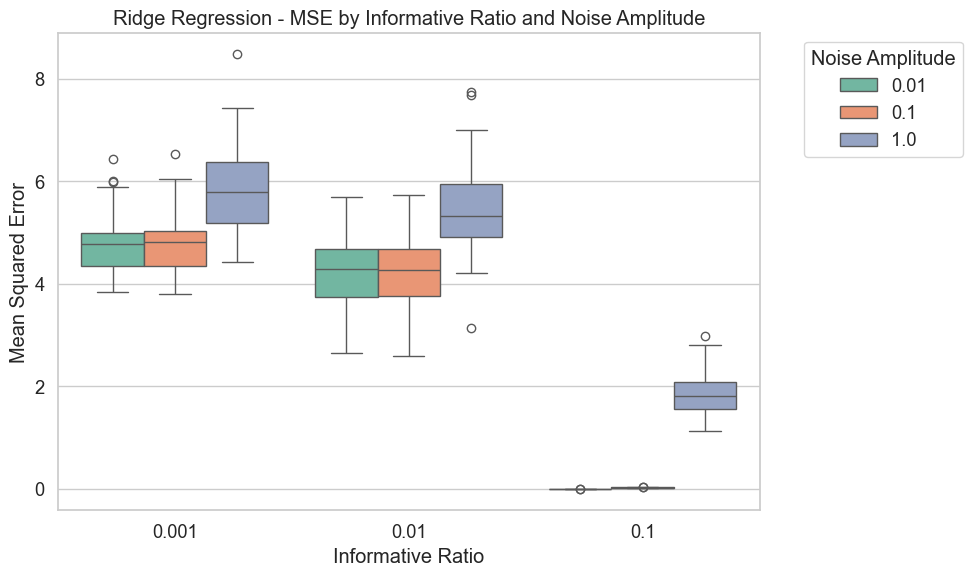

In [7]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot with hue for noise and group by informative ratio
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations,
    x="ir",          # Group by informative ratio on x-axis
    y="mse",         # MSE on y-axis
    hue="noise",     # Different colors for each noise level
    palette="Set2"   # You can change the palette as needed
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Ridge Regression - MSE by Informative Ratio and Noise Amplitude")

# Show legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

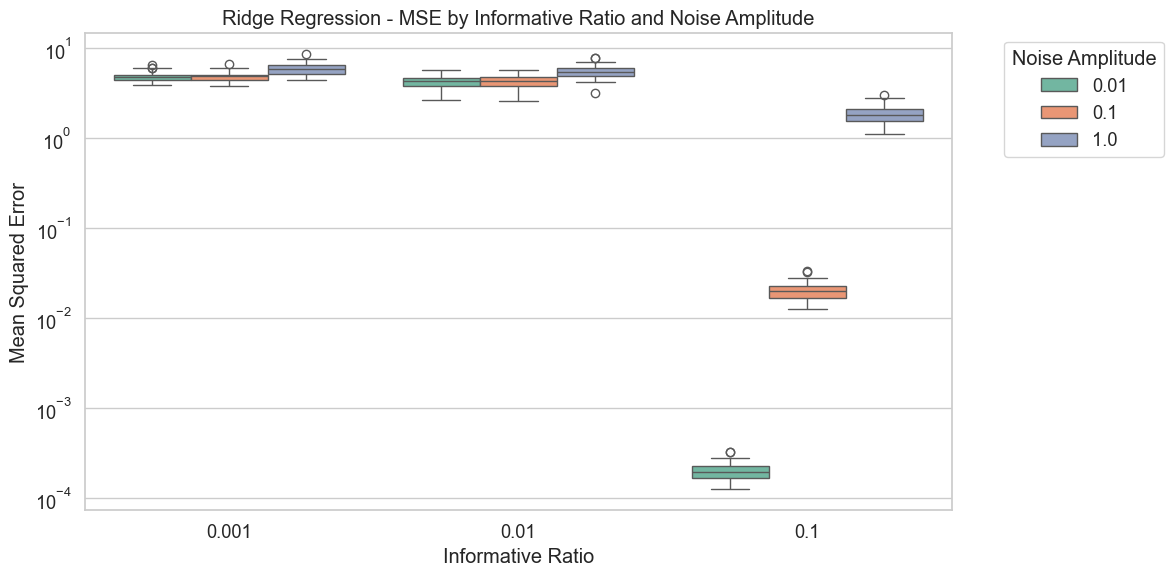

In [8]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations,
    x="ir",          # Informative ratio on x-axis
    y="mse",         # MSE on y-axis
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Ridge Regression - MSE by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

Graphs Simulations Feature Precision 5 and 10

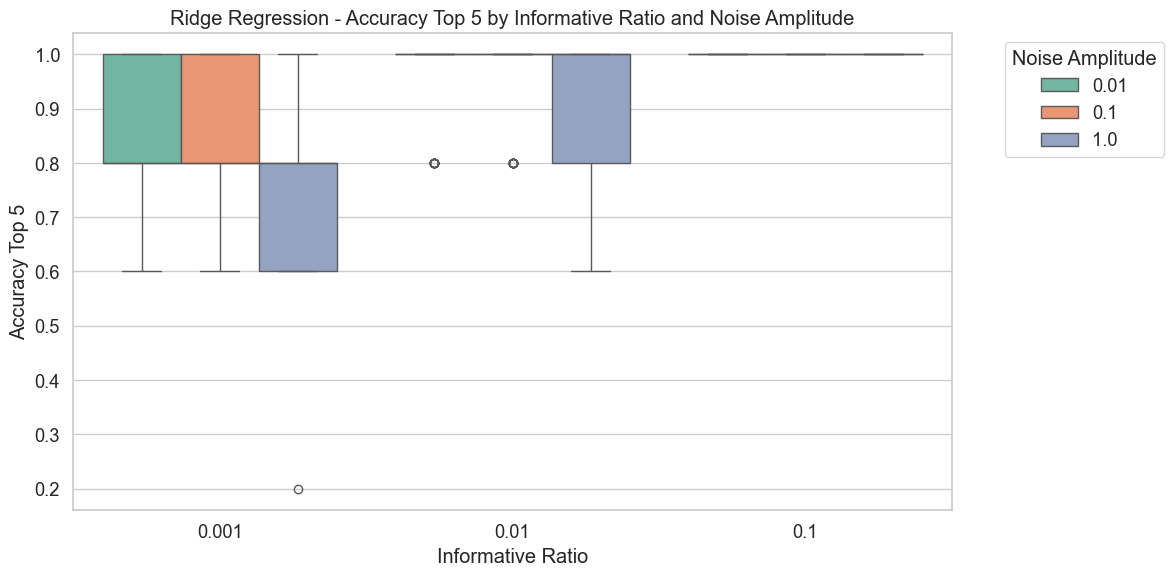

In [9]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations,
    x="ir",          # Informative ratio on x-axis
    y="precision5",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 5")
ax.set_title("Ridge Regression - Accuracy Top 5 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

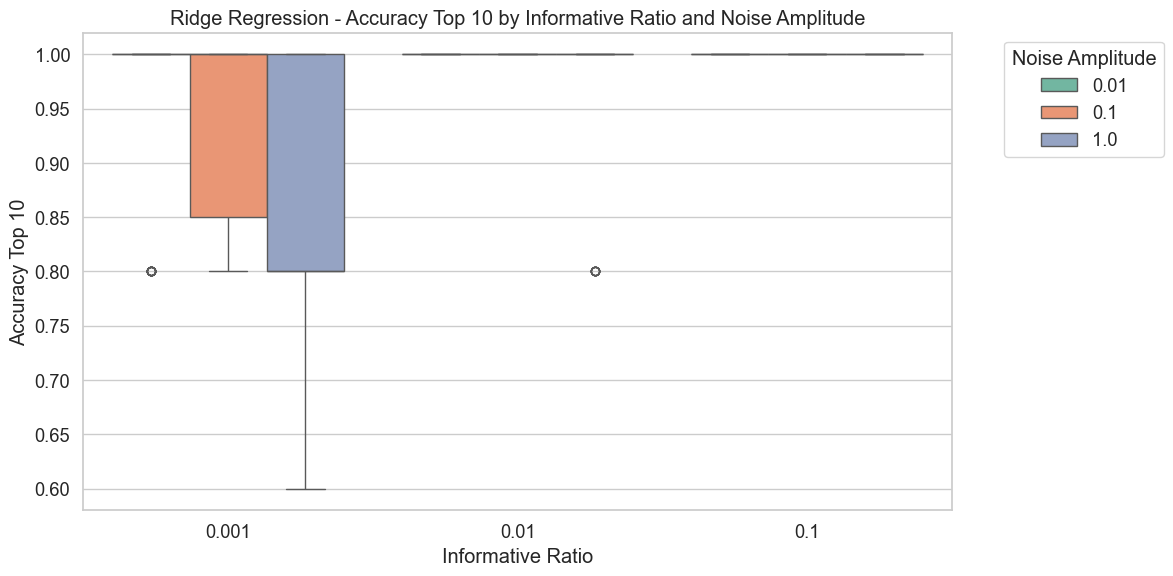

In [10]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations,
    x="ir",          # Informative ratio on x-axis
    y="precision10",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 10")
ax.set_title("Ridge Regression - Accuracy Top 10 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
#plt.legend(title="Noise Amplitude", loc="upper right")
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

## 1.3 Penalized Regression with Lasso (Linear)

#### 1.3.1 Dataframe Lasso: Vary noise amplitude, ratio informative and dataset size for linear data

In [11]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# alpha_grid = {'lasso__alpha': np.logspace(-4, 4, 30)}
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1, 1]
# n_informative = 5 # Always 5 informative features

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         alpha_list = []
#         selected_features_list = []
#         grid_time_list = []
#         model_coef_list = []
#         correct_selected_features_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = [] 

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_linear_data(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model pipeline with StandardScaler, Lasso and gridSearchCV
#             lasso_pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('lasso', Lasso(max_iter=10000, random_state=42))
#             ])

#             grid_search = GridSearchCV(
#                 lasso_pipeline,
#                 param_grid=alpha_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             coef = best_model.named_steps['lasso'].coef_
#             model_coef_list.append(coef)

#             # Best parameter
#             best_alpha = grid_search.best_params_['lasso__alpha']
#             alpha_list.append(best_alpha)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature selection
#             # Lasso automatically sets coefficients to zero, no need for a threshold
#             n_selected = np.sum(coef != 0)  
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(coef[:n_informative] != 0)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute coefficient magnitude and index
#             coef_magnitudes = np.abs(coef)
#             top_5_indices = np.argsort(coef_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(coef_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of this simulation
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'features_informative': n_informative,
#                 'features_noninformative': n_features - n_informative,
#                 'simulation': sim,
#                 'mse': mse,
#                 'alpha': best_alpha,
#                 'selected_features': n_selected,
#                 'grid time': grid_time,
#                 'model_coef': coef.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })

#         # Save mean results
#         all_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'mean_mse': np.mean(mse_list),
#                 'std_mse': np.std(mse_list),
#                 'modus_alpha': mode(alpha_list, keepdims=True).mode[0],
#                 'mean_selected_total': np.mean(selected_features_list),
#                 'std_selected_total': np.std(selected_features_list),
#                 'mean_correct_selected': np.mean(correct_selected_features_list),
#                 'std_correct_selected': np.std(correct_selected_features_list),
#                 'mean_grid_time': np.mean(grid_time_list),
#                 'std_grid_time': np.std(grid_time_list),
#                 'mean_precision': np.mean(precision_list),
#                 'std_precision': np.std(precision_list),
#                 'mean_recall': np.mean(recall_list),
#                 'std_recall': np.std(recall_list),
#                 'p/n': n_features / n_observations_train,
#                 'mean_precision5': np.mean(precision5_list),
#                 'std_precision5': np.std(precision5_list),
#                 'mean_precision10': np.mean(precision10_list),
#                 'std_precision10': np.std(precision10_list),
#             })
        
# # === Save results to CSV ===
# df_Lasso = pd.DataFrame(all_results)
# df_Lasso.to_csv('df_Lasso_high_dim_linear_all_results.csv', index=False)
# print("DataFrame Lasso has been saved as CSV file.")

# df_Lasso_simulations = pd.DataFrame(all_simulation_results)
# df_Lasso_simulations.to_csv('df_Lasso_high_dim_linear_simulations.csv', index=False)
# print("Saved detailed Lasso simulation results to 'df_Lasso_high_dim_linear_simulations.csv'")


### 1.3.2 Visualisation Lasso Dataframe

Read Data

In [12]:
# Lasso 50 sim
df_Lasso = pd.read_csv("df_Lasso_high_dim_linear_all_results.csv")
df_Lasso_simulations = pd.read_csv("df_Lasso_high_dim_linear_simulations.csv")

In [13]:
print(df_Lasso.columns)
print(df_Lasso_simulations.columns)

Index(['noise', 'ir', 'features', 'mean_mse', 'std_mse', 'modus_alpha',
       'mean_selected_total', 'std_selected_total', 'mean_correct_selected',
       'std_correct_selected', 'mean_grid_time', 'std_grid_time',
       'mean_precision', 'std_precision', 'mean_recall', 'std_recall', 'p/n',
       'mean_precision5', 'std_precision5', 'mean_precision10',
       'std_precision10'],
      dtype='object')
Index(['noise', 'ir', 'features', 'features_informative',
       'features_noninformative', 'simulation', 'mse', 'alpha',
       'selected_features', 'grid time', 'model_coef',
       'correct_selected_features', 'p/n', 'precision', 'recall', 'precision5',
       'precision10'],
      dtype='object')


Graphs Simulations MSE

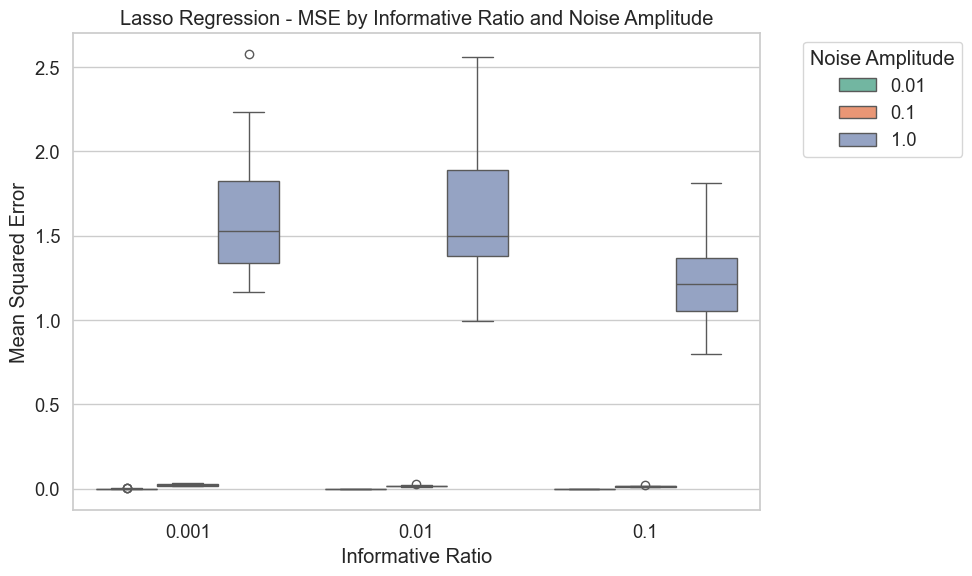

In [14]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot with hue for noise and group by informative ratio
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations,
    x="ir",
    y="mse",
    hue="noise",
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Lasso Regression - MSE by Informative Ratio and Noise Amplitude")

# Show legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


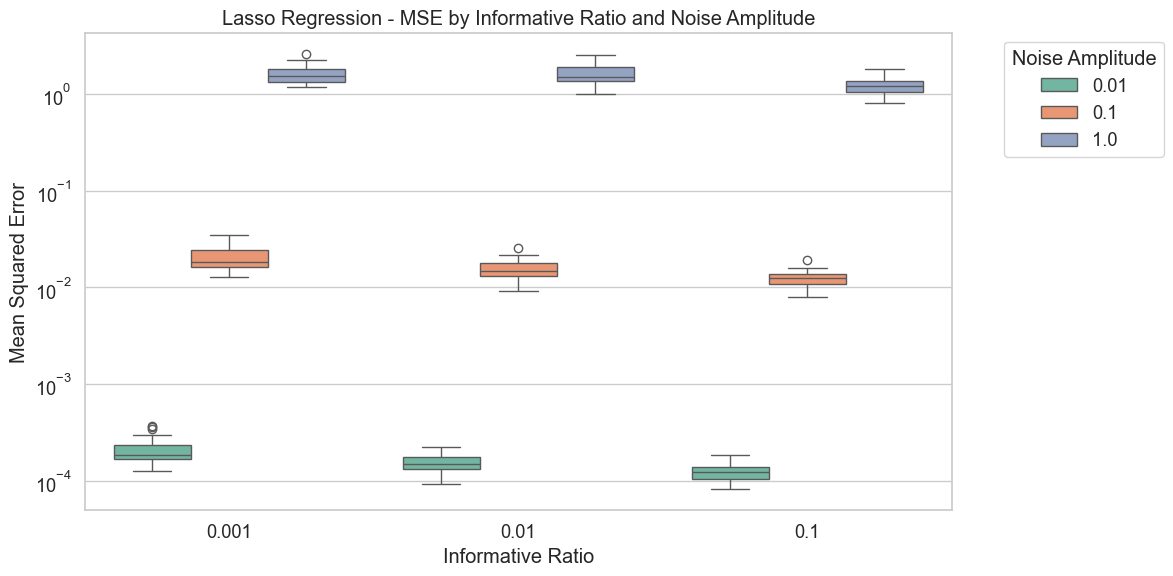

In [15]:
# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations,
    x="ir",
    y="mse",
    hue="noise",
    palette="Set2"
)

# Set labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Lasso Regression - MSE by Informative Ratio and Noise Amplitude")

# Log scale y-axis
ax.set_yscale("log")

plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


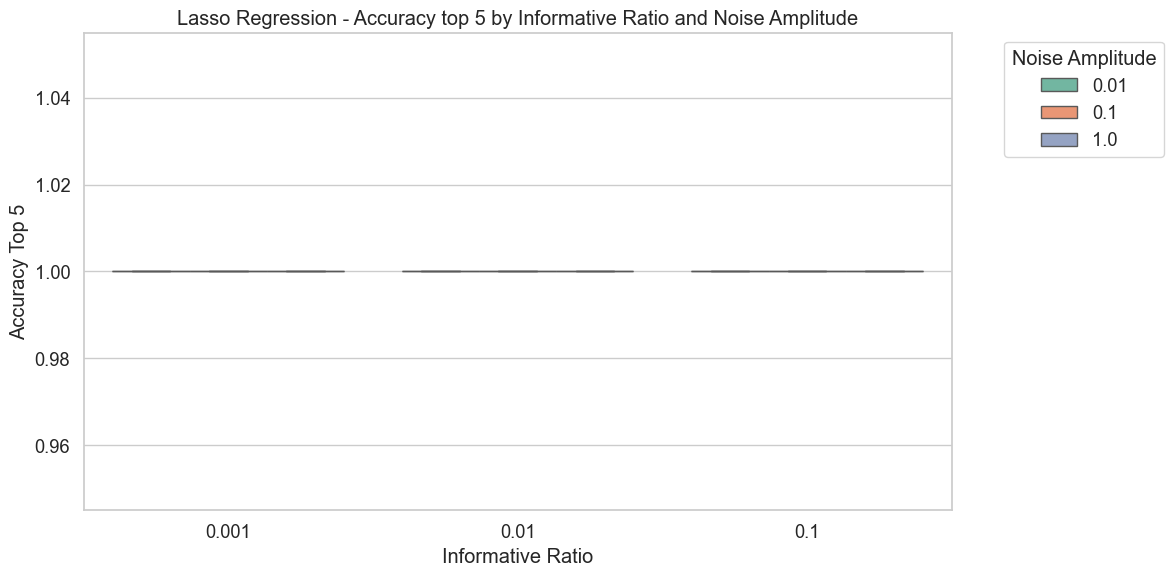

In [16]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations,
    x="ir",          # Informative ratio on x-axis
    y="precision5",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 5")
ax.set_title("Lasso Regression - Accuracy top 5 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

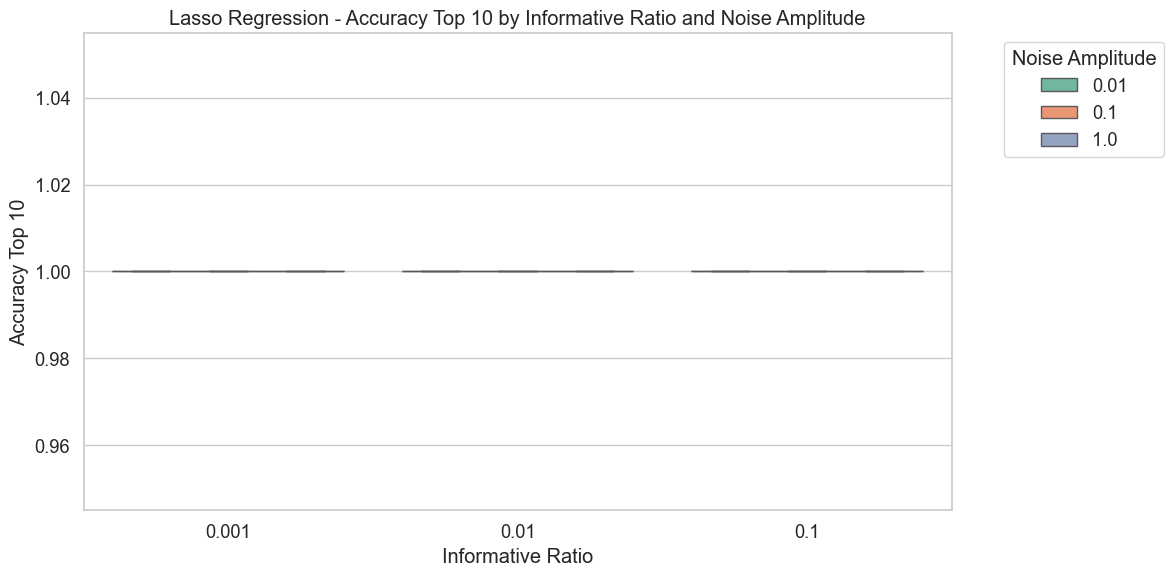

In [17]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations,
    x="ir",          # Informative ratio on x-axis
    y="precision10",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 10")
ax.set_title("Lasso Regression - Accuracy Top 10 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

True recall of Lasso = 1; True precision differs but in all simulation results it is very clear that the first 5 features are the most important ones (around 1) while maybe some X_i is around 0.0001 

## 1.4 Random Forest (Linear)

### 1.4.1 Dataframe Random Forest Linear data

In [18]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1, 1]
# n_informative = 5 # Always 5 informative features
# # The parameter grid is dynamic, thus not placed in this parameter list at the top

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         selected_features_list = []
#         best_params_list = []
#         grid_time_list = []
#         correct_selected_features_list = []
#         model_importance_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = [] 

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_linear_data(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model Random Forest and GridSearchCV
#             # No scaling needed for Random Forest
#             rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#             rf_param_grid = {
#                 'n_estimators': [100, 200, 300, 400, 500],  # Fixed number of estimators
#                 'max_depth': [None, 10, 20],
#                 'min_samples_split': [2, 5],
#                 'min_samples_leaf': [1, 2, 4],
#                 'max_features': ['sqrt','log2', 1, max(1, n_features // 3)] # p/3 added
#             }
            
#             grid_search = GridSearchCV(
#                 rf,
#                 param_grid=rf_param_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             model_importance_list.append(best_model.feature_importances_)

#             # Best parameter
#             best_params = grid_search.best_params_
#             best_params_list.append(best_params)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature Selection
#             importance_threshold = 1e-3
#             model_importance = best_model.feature_importances_
#             n_selected = np.sum(model_importance > importance_threshold)
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(np.abs(best_model.feature_importances_[:n_informative]) > importance_threshold)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute importance magnitude and index
#             importance_magnitudes = np.abs(model_importance)
#             top_5_indices = np.argsort(importance_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(importance_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of the simulations
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'simulation': sim,
#                 'mse': mse,
#                 'selected_features': n_selected,
#                 'n_estimators': best_params['n_estimators'],
#                 'max_depth': best_params['max_depth'],
#                 'min_samples_split': best_params['min_samples_split'],
#                 'min_samples_leaf': best_params['min_samples_leaf'],
#                 'max_features': best_params['max_features'],
#                 'grid_time' : grid_time,
#                 'model_importance' : model_importance.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })   

#         # get mode per parameter
#         def get_mode(lst):
#             return Counter(lst).most_common(1)[0][0]

#         # Extract each parameter list
#         n_estimators_modes = get_mode([p['n_estimators'] for p in best_params_list])
#         max_depth_modes = get_mode([p['max_depth'] for p in best_params_list])
#         min_samples_split_modes = get_mode([p['min_samples_split'] for p in best_params_list])
#         min_samples_leaf_modes = get_mode([p['min_samples_leaf'] for p in best_params_list])
#         max_features_modes = get_mode([p['max_features'] for p in best_params_list])

#         # Save the mean results      
#         all_results.append({
#             'noise': noise_amplitude,
#             'ir': informative_ratio,
#             'features': n_features,
#             'mean_mse': np.mean(mse_list),
#             'std_mse': np.std(mse_list),
#             'mean_selected': np.mean(selected_features_list),
#             'std_selected': np.std(selected_features_list),
#             'mode_n_estimators': n_estimators_modes,
#             'mode_max_depth': max_depth_modes,
#             'mode_min_samples_split': min_samples_split_modes,
#             'mode_min_samples_leaf': min_samples_leaf_modes,
#             'mode_max_features': max_features_modes,
#             'mean_grid_time' : np.mean(grid_time_list),
#             'std_grid_time' : np.std(grid_time_list),
#             'mean_correct_selected': np.mean(correct_selected_features_list),
#             'std_correct_selected': np.std(correct_selected_features_list),
#             'mean_precision': np.mean(precision_list),
#             'std_precision': np.std(precision_list),
#             'mean_recall': np.mean(recall_list),
#             'std_recall': np.std(recall_list),
#             'p/n': n_features / n_observations_train,
#             'mean_precision5': np.mean(precision5_list),
#             'std_precision5': np.std(precision5_list),
#             'mean_precision10': np.mean(precision10_list),
#             'std_precision10': np.std(precision10_list),
#         })
        
# # === Save results to CSV ===
# df_RF = pd.DataFrame(all_results)
# df_RF.to_csv('df_RF_high_dim_linear_all_results.csv', index=False)
# print("DataFrame RF has been saved as CSV file.")

# df_RF_simulations = pd.DataFrame(all_simulation_results)
# df_RF_simulations.to_csv('df_RF_high_dim_linear_simulations.csv', index=False)
# print("Saved detailed RF simulation results to 'df_RF_high_dim_linear_simulations.csv'")

### 1.4.2 Visualisation Random Forest Dataframe

Read Data

In [19]:
# RF 50 sim
df_RF = pd.read_csv("df_RF_high_dim_linear_all_results.csv")
df_RF_simulations = pd.read_csv("df_RF_high_dim_linear_simulations.csv")

In [20]:
print(df_RF.columns)
print(df_RF_simulations.columns)

Index(['noise', 'ir', 'features', 'mean_mse', 'std_mse', 'mean_selected',
       'std_selected', 'mode_n_estimators', 'mode_max_depth',
       'mode_min_samples_split', 'mode_min_samples_leaf', 'mode_max_features',
       'mean_grid_time', 'std_grid_time', 'mean_correct_selected',
       'std_correct_selected', 'mean_precision', 'std_precision',
       'mean_recall', 'std_recall', 'p/n', 'mean_precision5', 'std_precision5',
       'mean_precision10', 'std_precision10'],
      dtype='object')
Index(['noise', 'ir', 'features', 'simulation', 'mse', 'selected_features',
       'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
       'max_features', 'grid_time', 'model_importance',
       'correct_selected_features', 'p/n', 'precision', 'recall', 'precision5',
       'precision10'],
      dtype='object')


Graph Simulations MSE

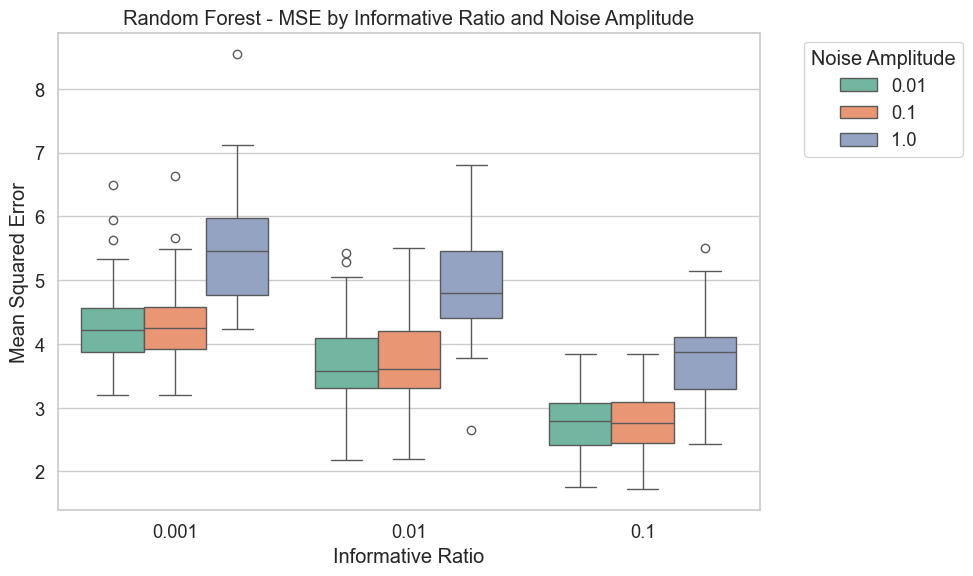

In [21]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_RF_simulations,
    x="ir",
    y="mse",
    hue="noise",
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Random Forest - MSE by Informative Ratio and Noise Amplitude")

# Show legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


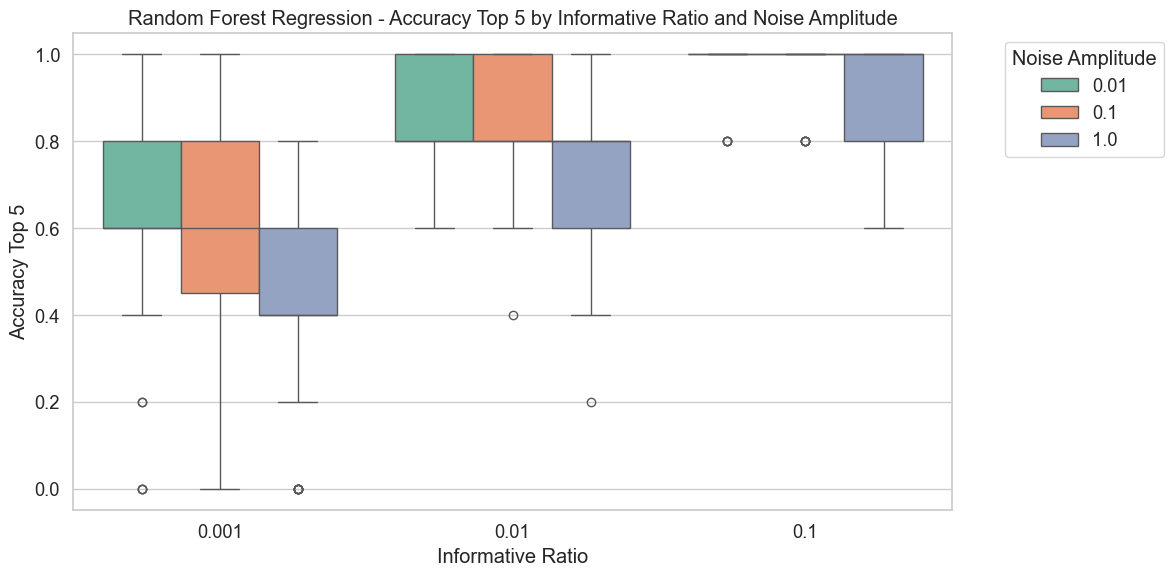

In [22]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_RF_simulations,
    x="ir",          # Informative ratio on x-axis
    y="precision5",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 5")
ax.set_title("Random Forest Regression - Accuracy Top 5 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

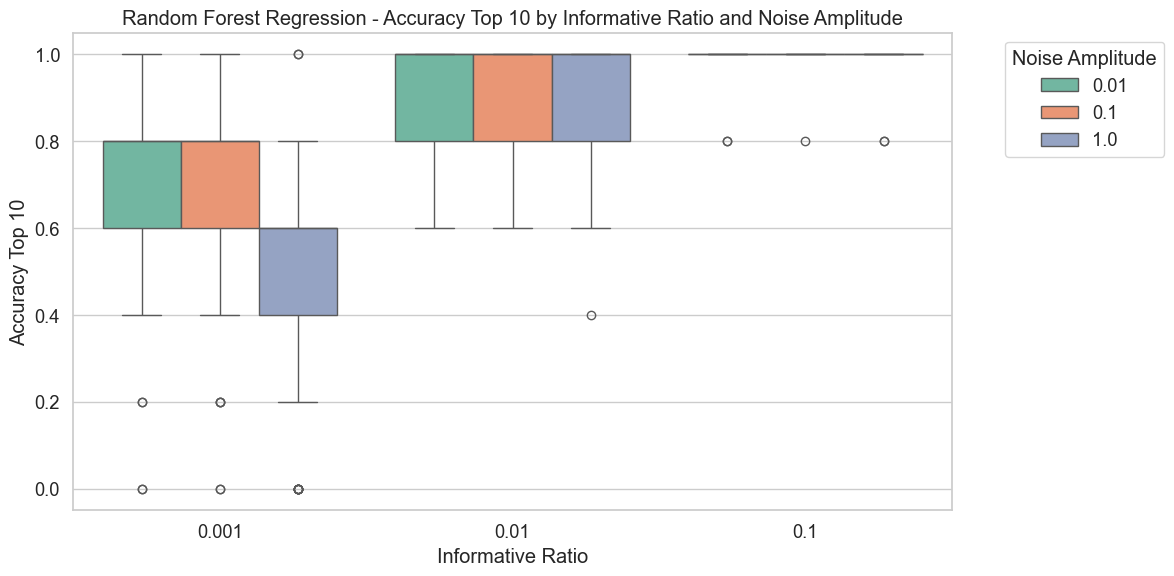

In [23]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_RF_simulations,
    x="ir",          # Informative ratio on x-axis
    y="precision10",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 10")
ax.set_title("Random Forest Regression - Accuracy Top 10 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

Graph Simulation Feature Precision

Graph Simulations Feature Recall

## 1.5 Results Linear Data

In [24]:
# Add a 'model' label
df_Ridge_simulations['model'] = 'Ridge'
df_Lasso_simulations['model'] = 'Lasso'
df_RF_simulations['model'] = 'Random Forest'

# Combine them
df_all = pd.concat([df_Ridge_simulations, df_Lasso_simulations, df_RF_simulations], ignore_index=True)


Visualise Results MSE

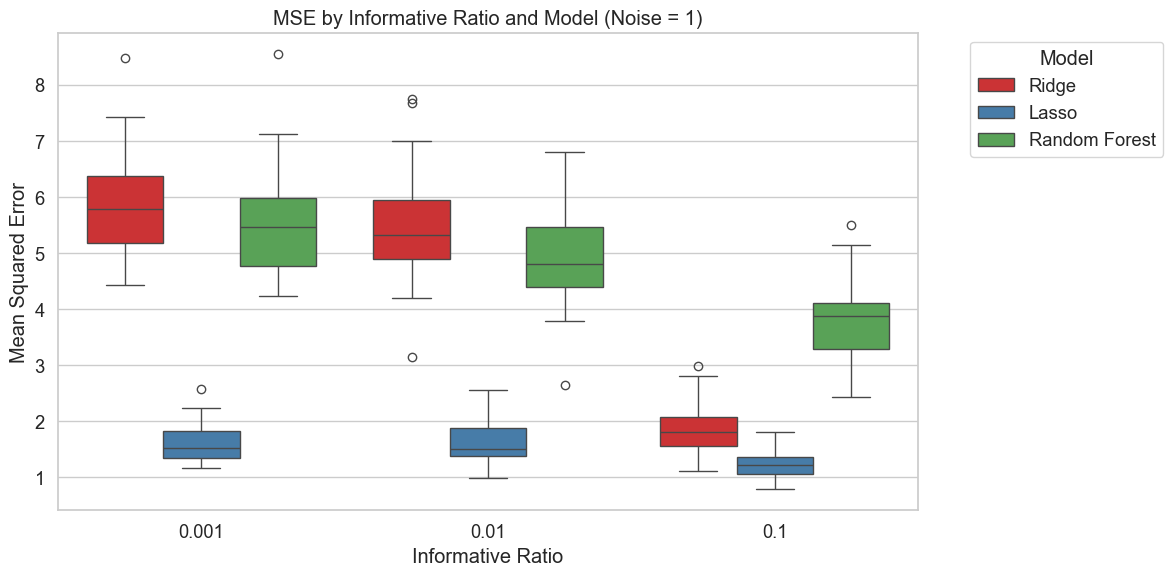

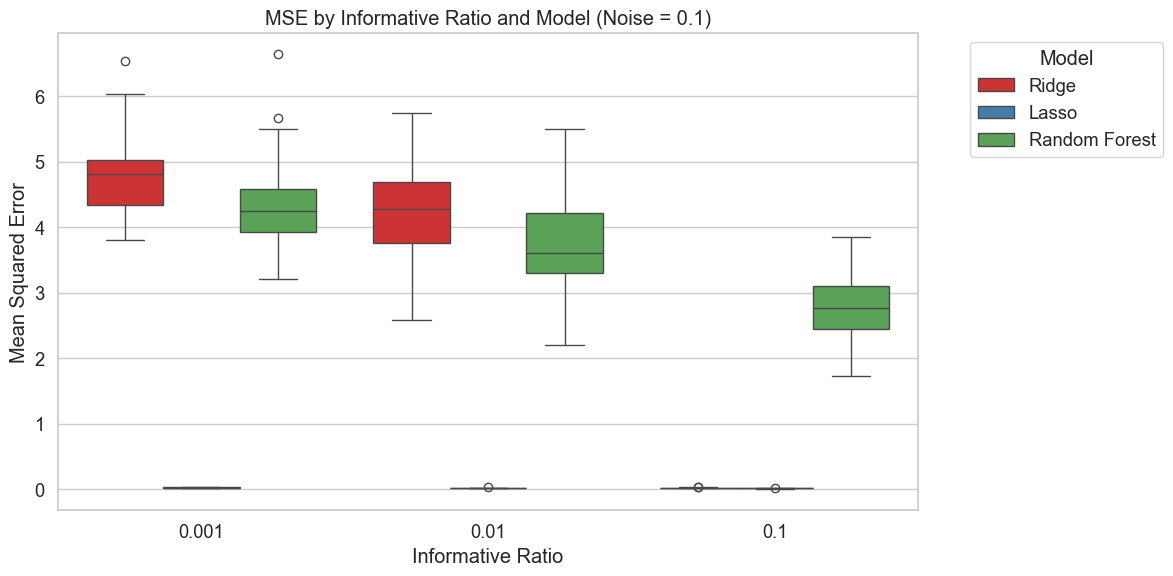

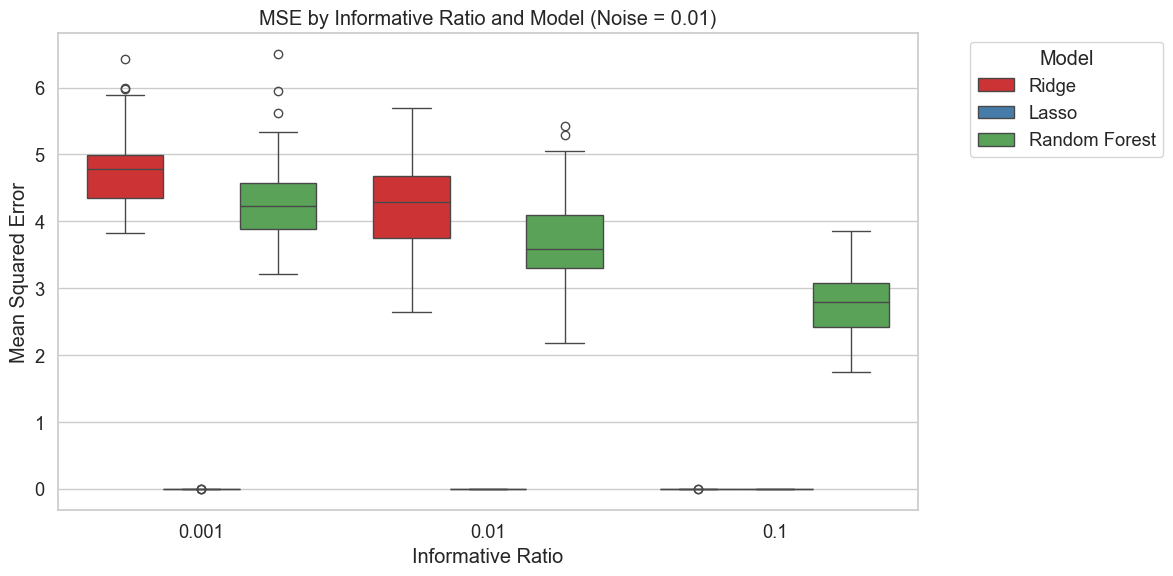

In [29]:
def plot_by_noise(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='mse',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'MSE by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Mean Squared Error')
    # Optional: uncomment next line for log scale
    # ax.set_yscale('log')

    #plt.legend(title='Model', loc='upper right')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise = 1
plot_by_noise(df_all, 1)

# Plot for noise = 0.1
plot_by_noise(df_all, 0.1)

# Plot for noise = 0.01
plot_by_noise(df_all, 0.01)

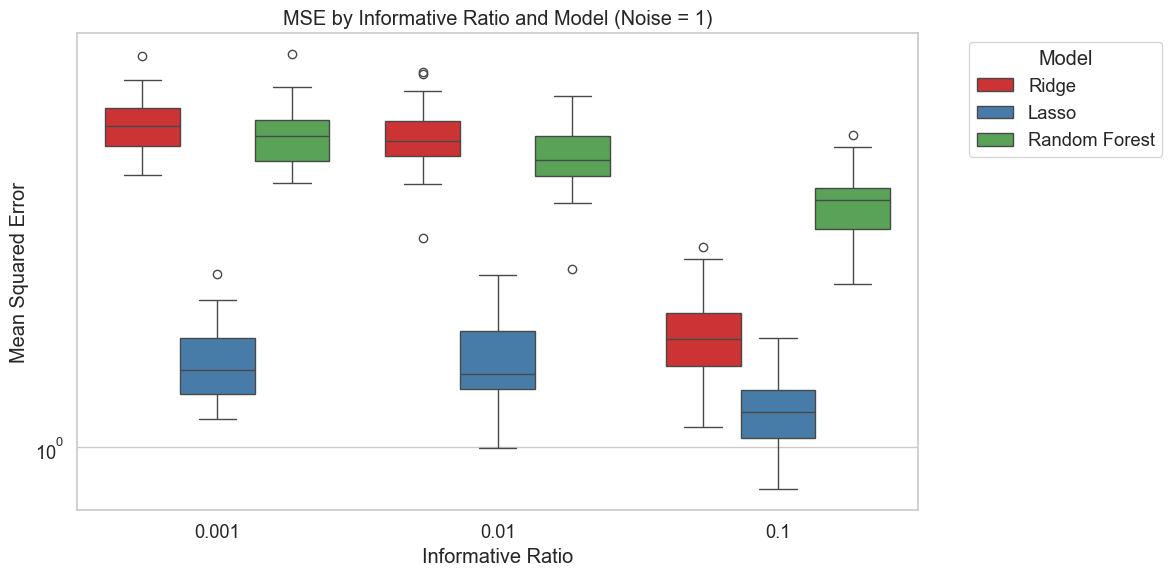

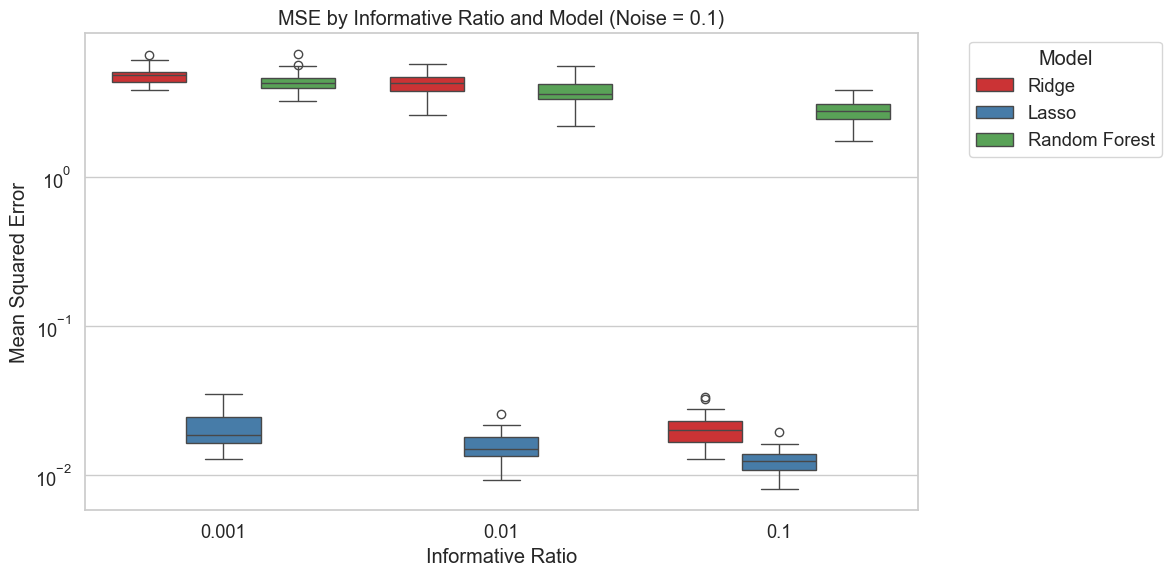

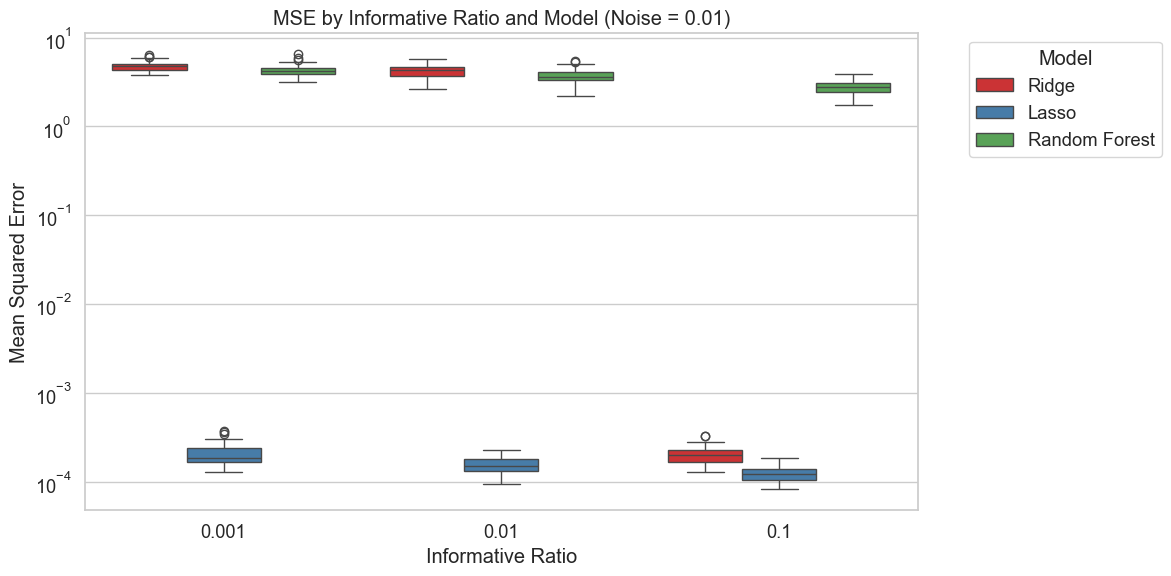

In [27]:
def plot_by_noise(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='mse',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'MSE by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Mean Squared Error')
    # Optional: uncomment next line for log scale
    ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise = 1
plot_by_noise(df_all, 1)

# Plot for noise = 0.1
plot_by_noise(df_all, 0.1)

# Plot for noise = 0.01
plot_by_noise(df_all, 0.01)

### Visualise results Precision

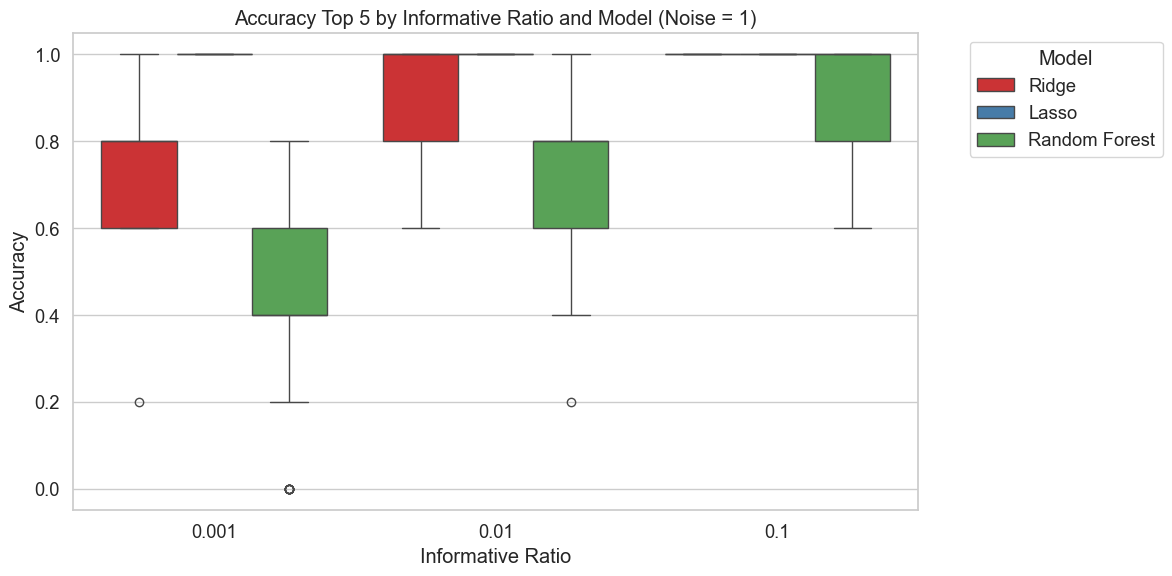

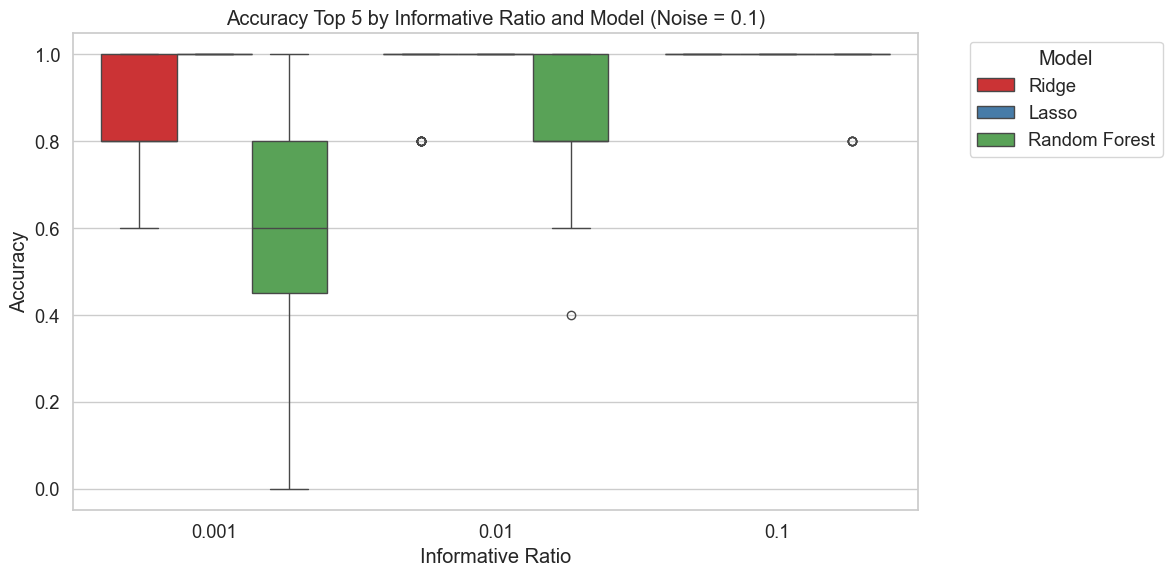

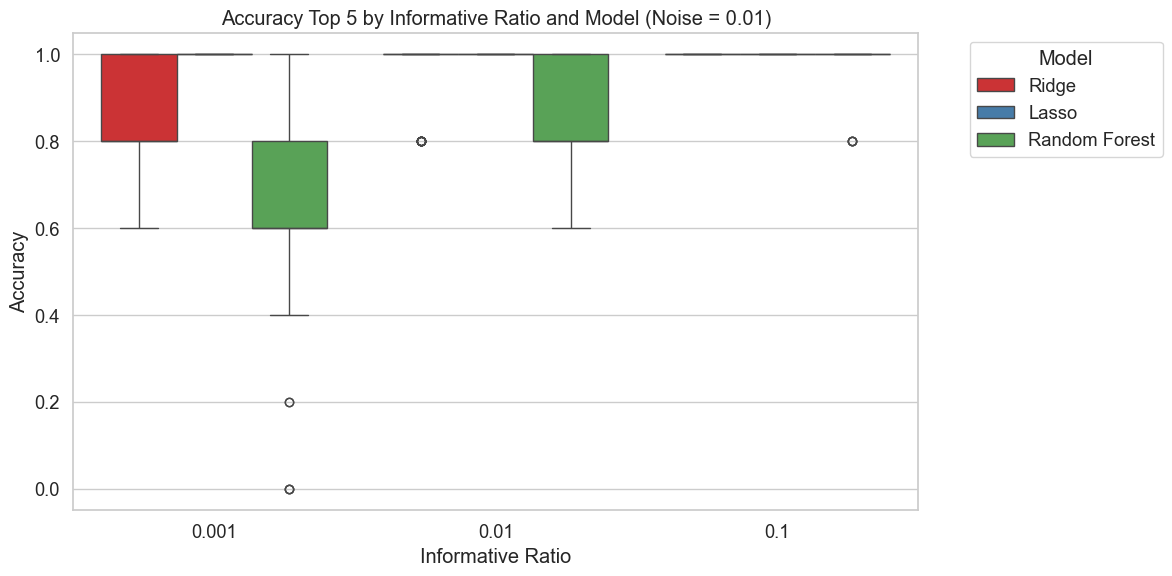

In [28]:
def plot_by_noise_precision(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='precision5',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'Accuracy Top 5 by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Accuracy')
    # Optional: uncomment next line for log scale
    # ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise =.1
plot_by_noise_precision(df_all, 1)


# Plot for noise = 0.1
plot_by_noise_precision(df_all, 0.1)

# Plot for noise = 0.01
plot_by_noise_precision(df_all, 0.01)

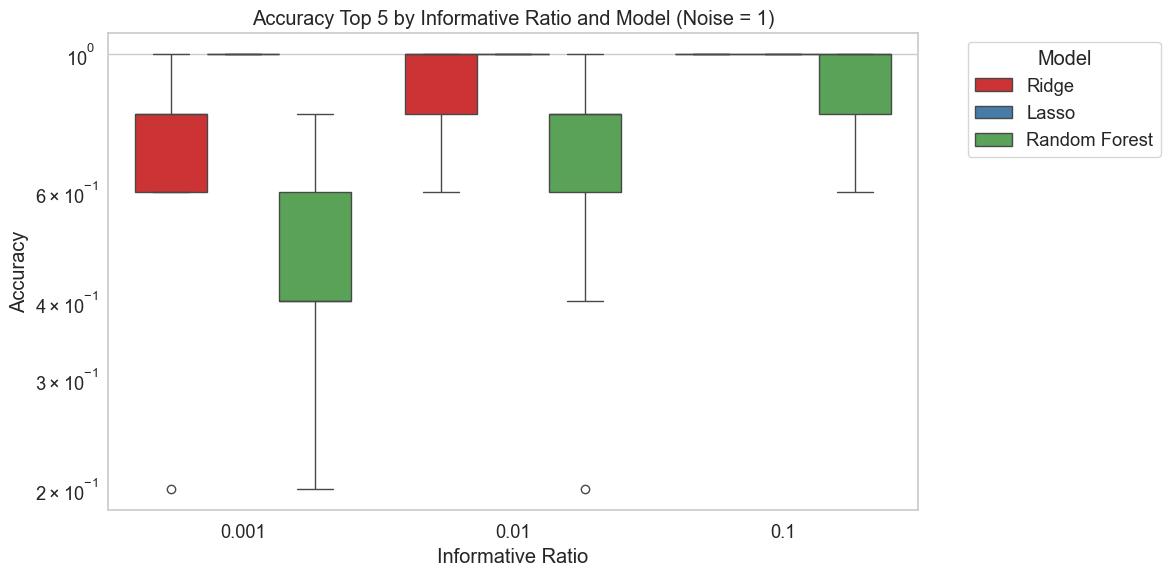

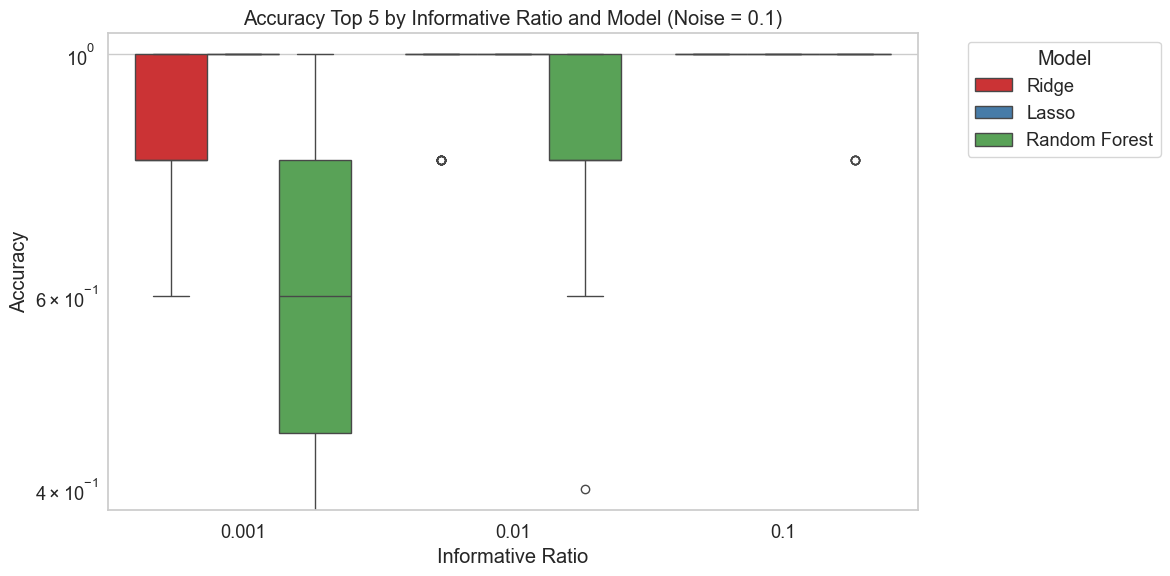

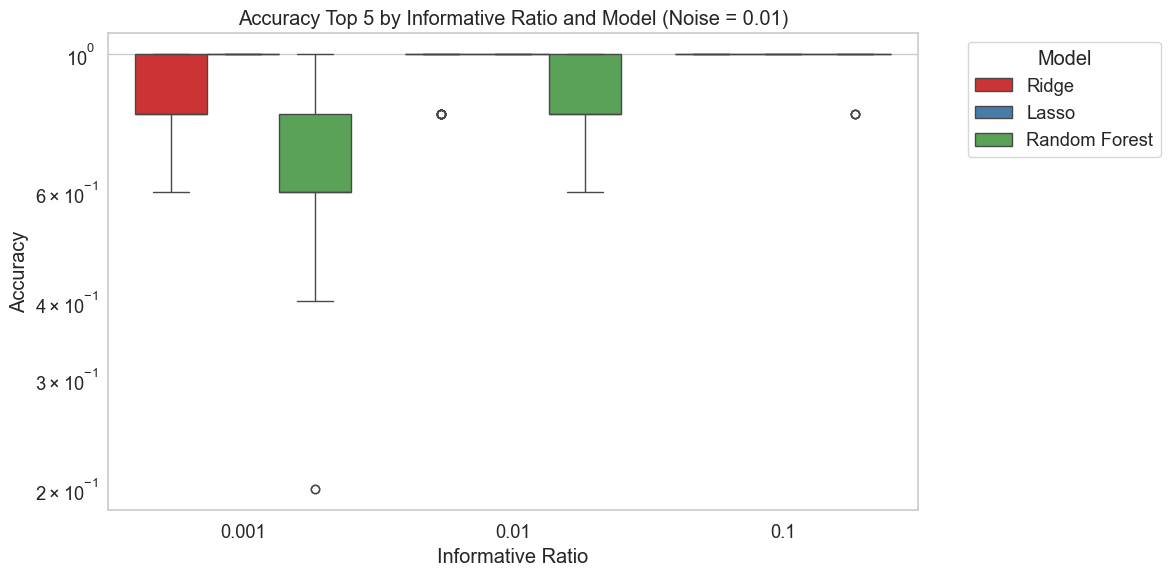

In [30]:
def plot_by_noise_precision(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='precision5',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'Accuracy Top 5 by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Accuracy')
    ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise = 1
plot_by_noise_precision(df_all, 1)

# Plot for noise = 0.1
plot_by_noise_precision(df_all, 0.1)

# Plot for noise = 0.01
plot_by_noise_precision(df_all, 0.01)

### Visualise results Recall

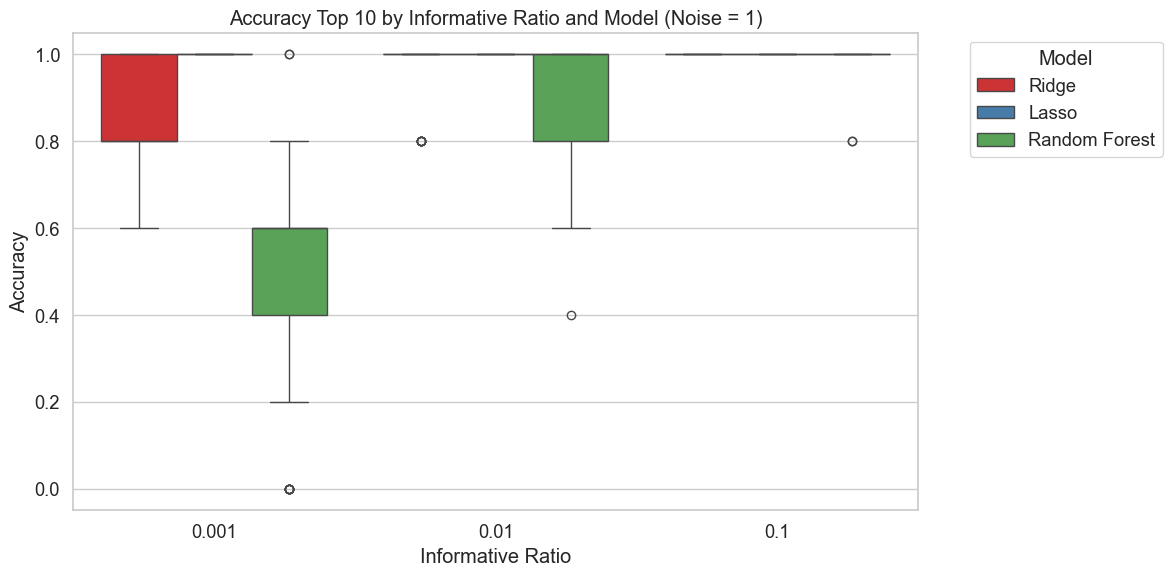

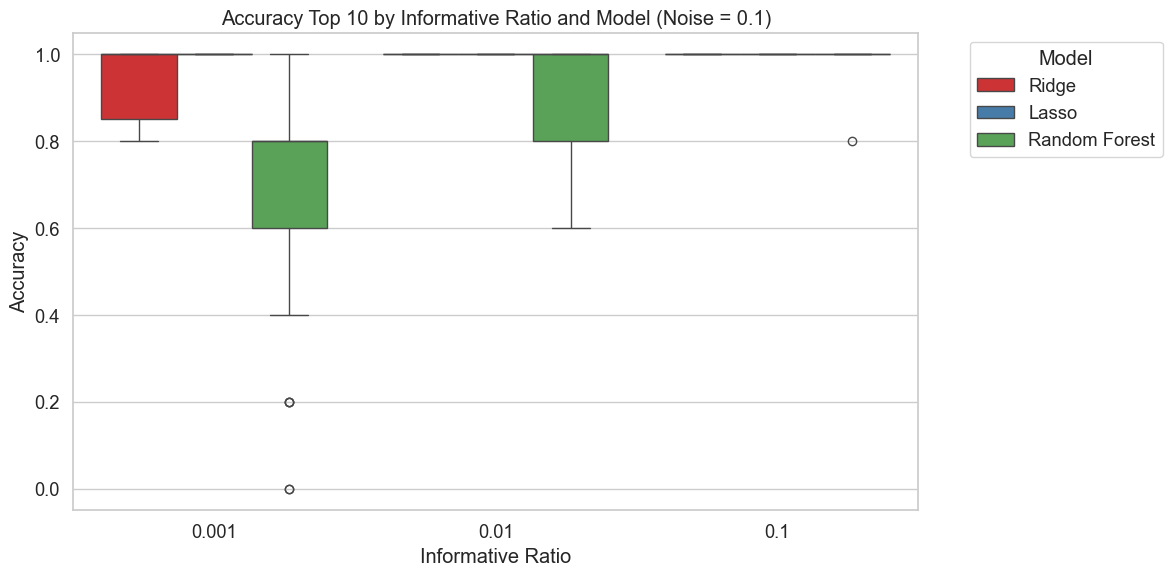

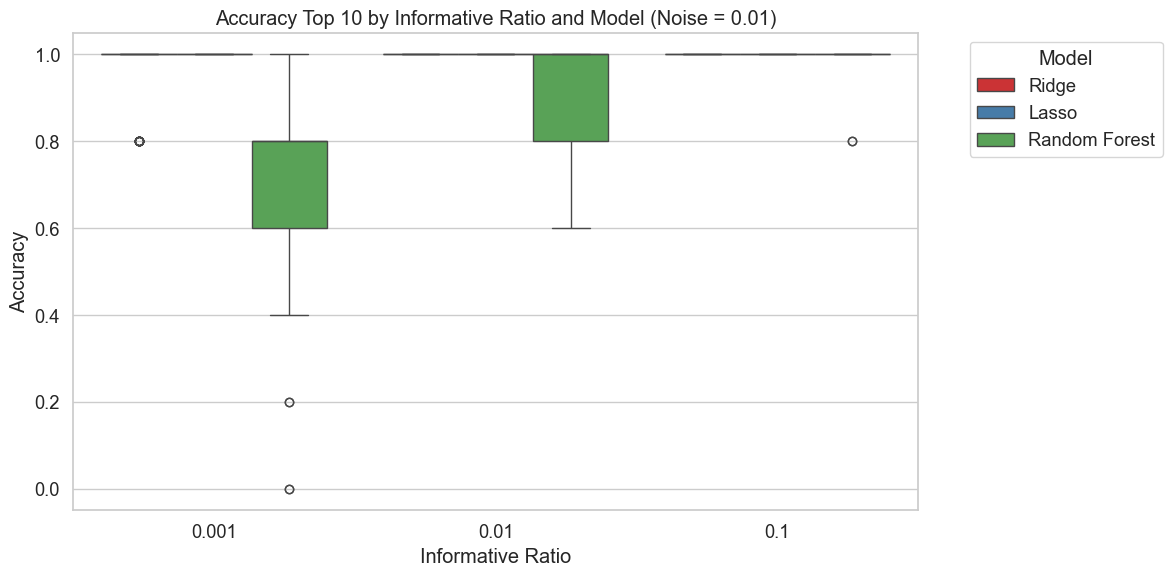

In [31]:
def plot_by_noise_precision(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='precision10',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'Accuracy Top 10 by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Accuracy')
    # Optional: uncomment next line for log scale
    # ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise = 1
plot_by_noise_precision(df_all, 1)

# Plot for noise = 0.1
plot_by_noise_precision(df_all, 0.1)

# Plot for noise = 0.01
plot_by_noise_precision(df_all, 0.01)

### Time

Fix new dataframe for fair comparison and plot graph

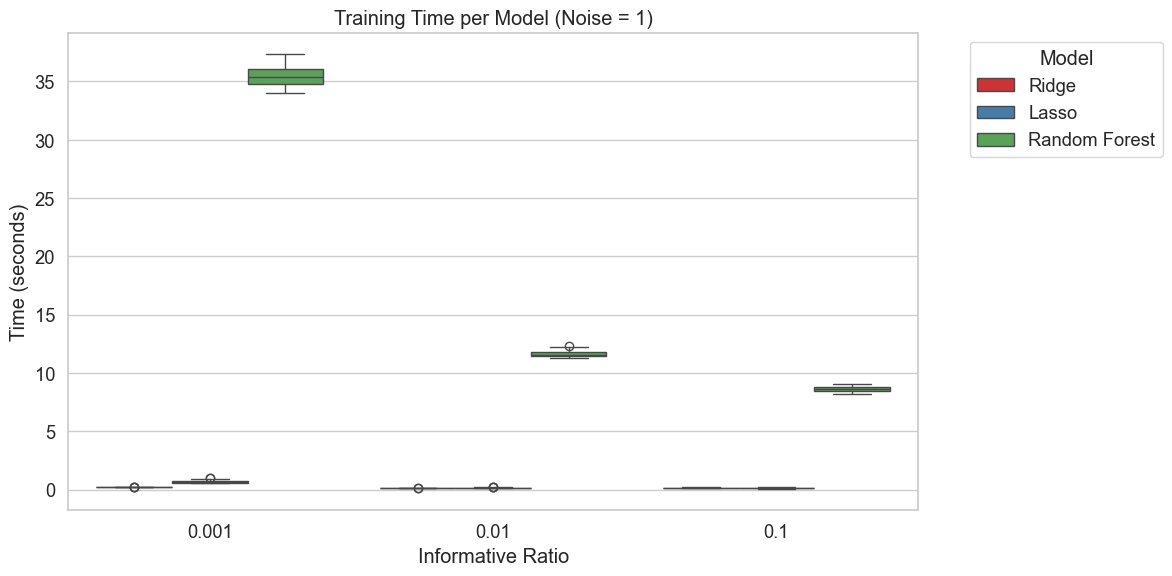

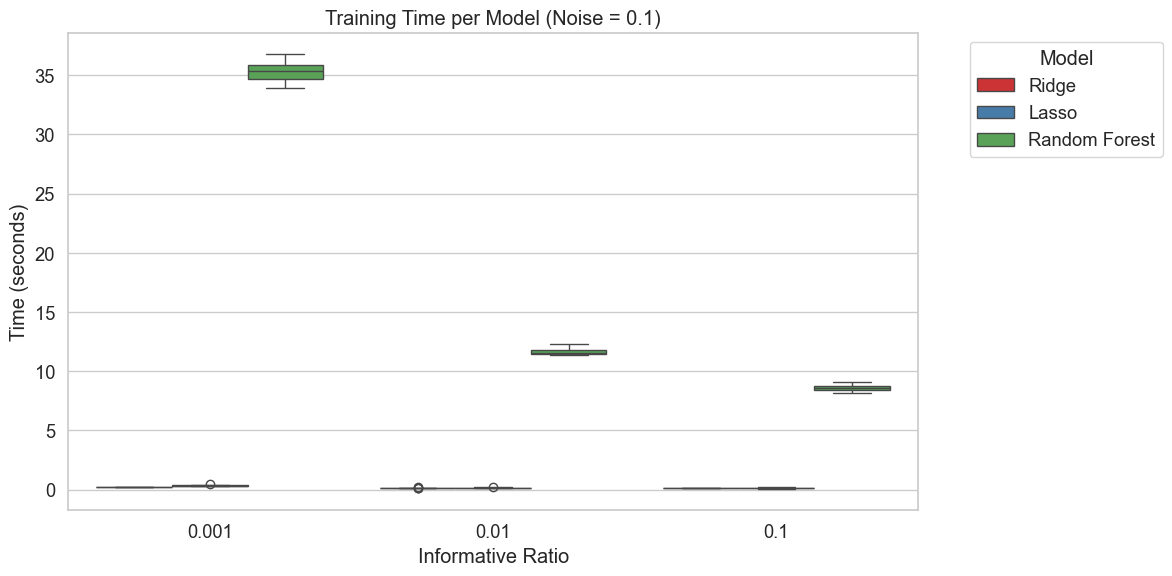

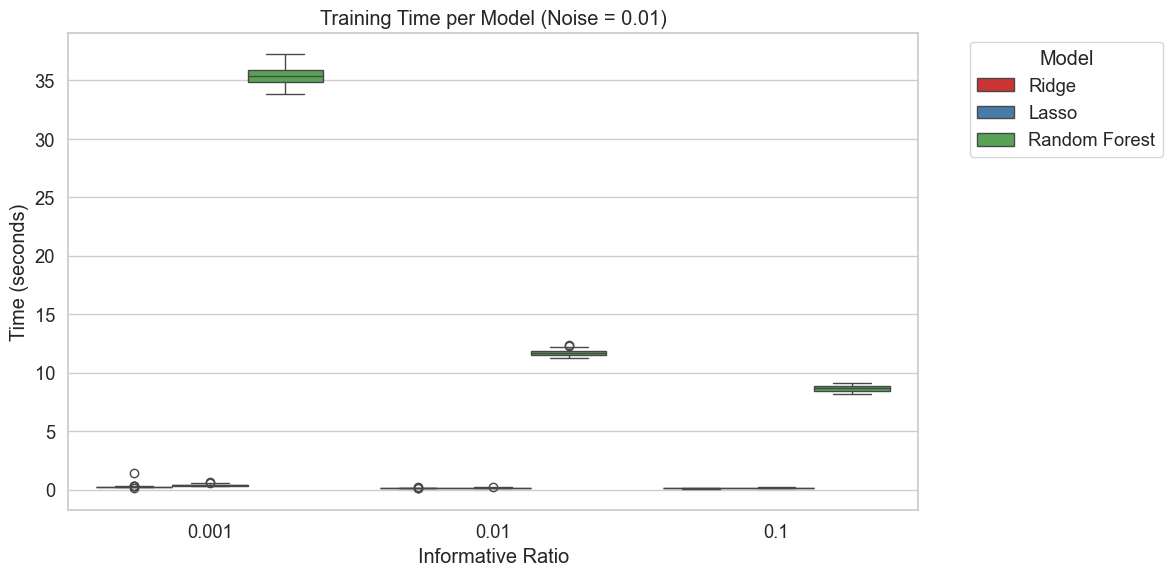

In [34]:
# Random Forest (RF)
df_RF_simulations['grid time'] = df_RF_simulations['grid_time'] 

df_Ridge_simulations['model'] = 'Ridge'
df_Lasso_simulations['model'] = 'Lasso'
df_RF_simulations['model'] = 'Random Forest'

df_combined = pd.concat([
    df_Ridge_simulations[['noise', 'ir', 'model', 'grid time']],
    df_Lasso_simulations[['noise', 'ir', 'model', 'grid time']],
    df_RF_simulations[['noise', 'ir', 'model', 'grid time']]
])

def plot_fair_fit_time(df, noise_level):
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',
        y='grid time',
        hue='model',
        palette='Set1',
        dodge=True
    )

    ax.set_title(f'Training Time per Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Time (seconds)')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_fair_fit_time(df_combined, 1)
plot_fair_fit_time(df_combined, 0.1)
plot_fair_fit_time(df_combined, 0.01)


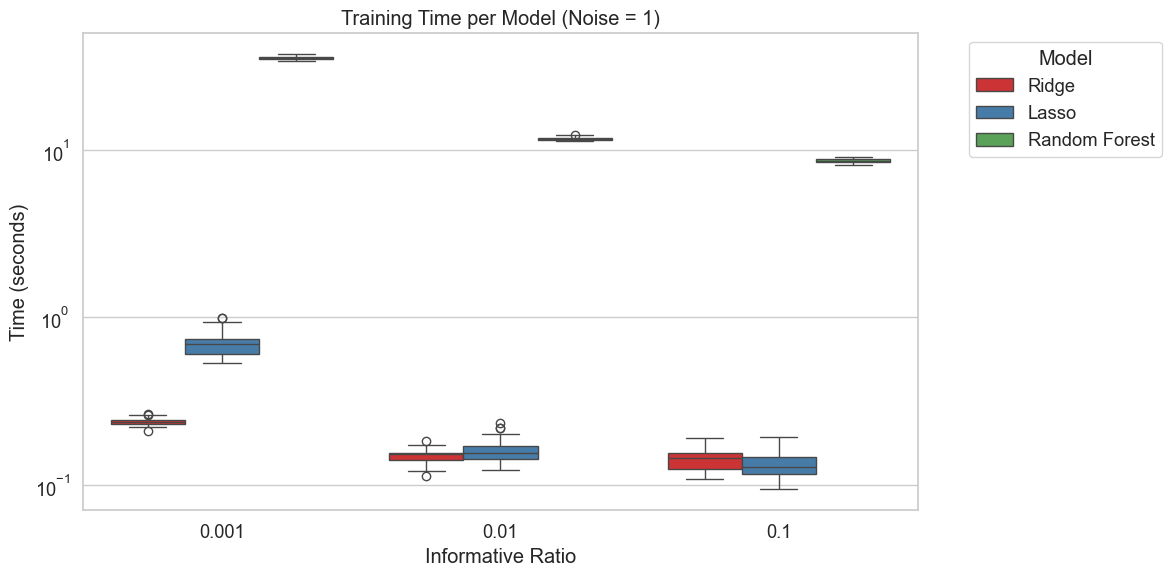

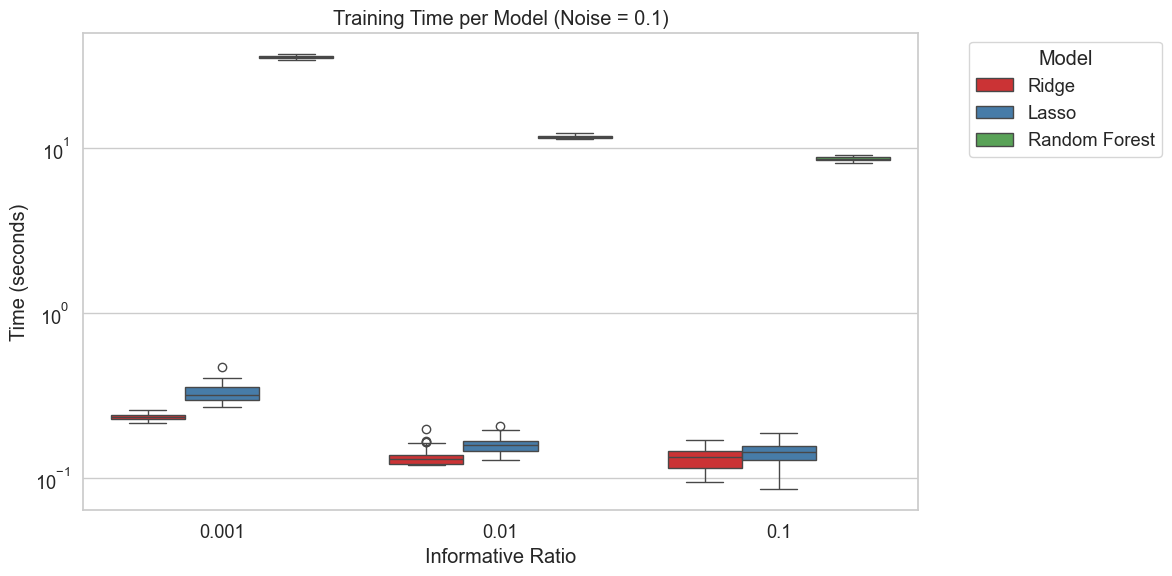

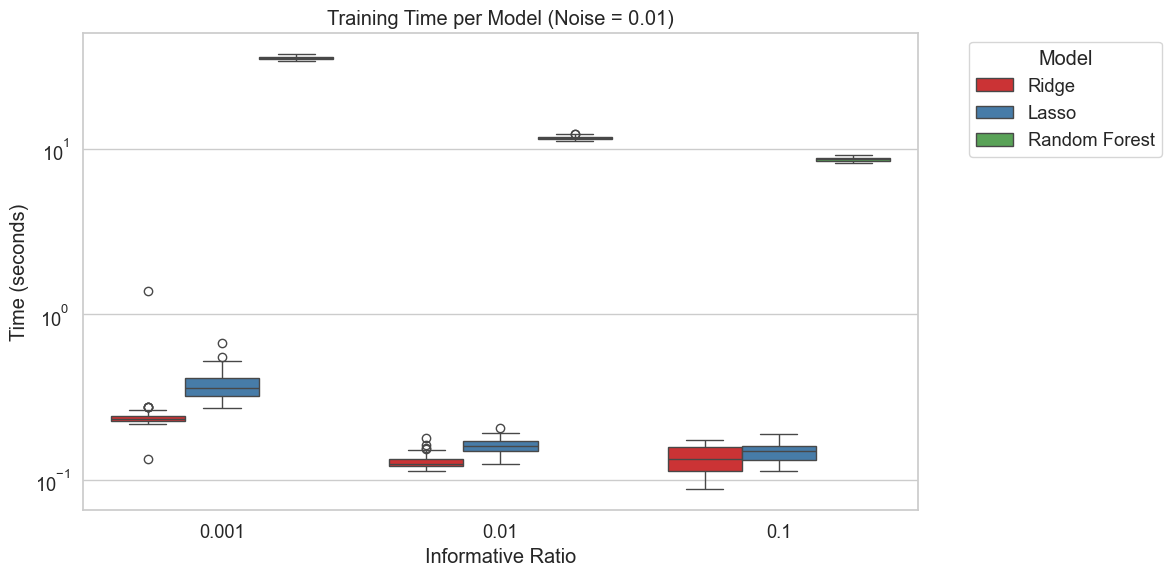

In [35]:
def plot_fair_fit_time(df, noise_level):
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',
        y='grid time',
        hue='model',
        palette='Set1',
        dodge=True
    )

    ax.set_title(f'Training Time per Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Time (seconds)')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

plot_fair_fit_time(df_combined, 1)
plot_fair_fit_time(df_combined, 0.1)
plot_fair_fit_time(df_combined, 0.01)



### Ordering

In [ ]:
sns.set(style="whitegrid")

# Define colors for models
model_colors = {'Ridge': 'tab:blue', 'Lasso': 'tab:orange', 'RF': 'tab:green'}

# Load and filter data for noise=0.01
def prepare_data(df):
    df_filtered = df[df['noise'] == 1].copy()
    df_filtered['model_coef'] = df_filtered['model_coef'].apply(ast.literal_eval)
    return df_filtered

def prepare_data_RF(df):
    df_filtered = df[df['noise'] == 0.01].copy()
    df_filtered['model_importance'] = df_filtered['model_importance'].apply(ast.literal_eval)
    return df_filtered

df_ridge = prepare_data(df_Ridge_simulations)
df_lasso = prepare_data(df_Lasso_simulations)
df_rf = prepare_data_RF(df_RF_simulations)

ir_list = [0.1, 0.01, 0.001]

for ir in ir_list:
    # Filter each dataframe by ir
    ridge_ir = df_ridge[df_ridge['ir'] == ir]
    lasso_ir = df_lasso[df_lasso['ir'] == ir]
    rf_ir = df_rf[df_rf['ir'] == ir]
    
    # Extract first 5 coefficients for each model
    def extract_coefs(df):
        coeffs = {i: [] for i in range(5)}
        for coefs_list in df['model_coef']:
            for i in range(5):
                coeffs[i].append(coefs_list[i])
        return coeffs
    
        # Extract first 5 coefficients for each model
    def extract_coefs_RF(df):
        coeffs = {i: [] for i in range(5)}
        for coefs_list in df['model_importance']:
            for i in range(5):
                coeffs[i].append(coefs_list[i])
        return coeffs

    ridge_coefs = extract_coefs(ridge_ir)
    lasso_coefs = extract_coefs(lasso_ir)
    rf_coefs = extract_coefs_RF(rf_ir)


    # Organize data for grouped boxplot
    # For each coefficient index, we want 3 datasets (ridge, lasso, rf)
    data = []
    labels = []
    for i in range(5):
        data.append(ridge_coefs[i])
        data.append(lasso_coefs[i])
        data.append(rf_coefs[i])
        labels.extend([f'Coef {i+1}\nRidge', f'Coef {i+1}\nLasso', f'Coef {i+1}\nRF'])

    # Plot
    plt.figure(figsize=(14, 8))
    box = plt.boxplot(data, patch_artist=True)

    # Set colors per model within each group of 3 boxes
    for i, patch in enumerate(box['boxes']):
        # Determine model by box index mod 3
        model_idx = i % 3
        if model_idx == 0:
            patch.set_facecolor(model_colors['Ridge'])
        elif model_idx == 1:
            patch.set_facecolor(model_colors['Lasso'])
        else:
            patch.set_facecolor(model_colors['RF'])
        patch.set_alpha(0.7)

    # Set median line color
    for median in box['medians']:
        median.set(color='firebrick', linewidth=2)

    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
    plt.ylabel('Coefficient Values', fontsize=14)
    plt.title(f'Comparison of First 5 Coefficients\nNoise=0.01, Informative Ratio={ir}', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add legend manually
    from matplotlib.patches import Patch
    legend_handles = [Patch(color=color, label=model) for model, color in model_colors.items()]
    plt.legend(handles=legend_handles, title='Model', fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
output_dir = "figures Theta"
os.makedirs(output_dir, exist_ok=True)

for noise_amplitude in [0.01, 0.1, 1]:   
    sns.set(style="whitegrid")

    model_colors = {'Ridge': 'tab:blue', 'Lasso': 'tab:orange', 'RF': 'tab:green'}

    def prepare_data(df, column='model_coef'):
        df_filtered = df[df['noise'] == noise_amplitude].copy()
        df_filtered[column] = df_filtered[column].apply(ast.literal_eval)
        return df_filtered

    df_ridge = prepare_data(df_Ridge_simulations, 'model_coef')
    df_lasso = prepare_data(df_Lasso_simulations, 'model_coef')
    df_rf = prepare_data(df_RF_simulations, 'model_importance')

    # Check if all Random Forest importances are already normalized
    all_normalized = True
    for coefs_list in df_rf['model_importance']:
        abs_vals = np.abs(coefs_list)
        norm = abs_vals / np.sum(abs_vals)
        if not np.allclose(norm, coefs_list):
            all_normalized = False
            break

    print("All RF importances already normalized:", all_normalized)


    ir_list = [0.1, 0.01, 0.001]

    for ir in ir_list:
        ridge_ir = df_ridge[df_ridge['ir'] == ir]
        lasso_ir = df_lasso[df_lasso['ir'] == ir]
        rf_ir = df_rf[df_rf['ir'] == ir]

        def extract_normalized(df, col_name):
            coeffs = {i: [] for i in range(5)}
            for coefs_list in df[col_name]:
                abs_vals = np.abs(coefs_list)
                norm = abs_vals / (np.sum(abs_vals))  
                for i in range(5):
                    coeffs[i].append(norm[i])
            return coeffs

        ridge_coefs = extract_normalized(ridge_ir, 'model_coef')
        lasso_coefs = extract_normalized(lasso_ir, 'model_coef')
        rf_coefs = extract_normalized(rf_ir, 'model_importance')

        data = []
        labels = []
        for i in range(5):
            data.append(ridge_coefs[i])
            data.append(lasso_coefs[i])
            data.append(rf_coefs[i])
            labels.extend([f'Coef {i+1}\nRidge', f'Coef {i+1}\nLasso', f'Coef {i+1}\nRF'])

        plt.figure(figsize=(14, 8))
        box = plt.boxplot(data, patch_artist=True)

        for i, patch in enumerate(box['boxes']):
            model_idx = i % 3
            if model_idx == 0:
                patch.set_facecolor(model_colors['Ridge'])
            elif model_idx == 1:
                patch.set_facecolor(model_colors['Lasso'])
            else:
                patch.set_facecolor(model_colors['RF'])
            patch.set_alpha(0.7)

        for median in box['medians']:
            median.set(color='firebrick', linewidth=2)

        plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, fontsize=12)
        plt.ylabel('Normalized Coefficient Magnitude', fontsize=14)
        plt.title(f'Relative Importance of Informative Coefficients\nNoise = {noise_amplitude}, Informative Ratio={ir}', fontsize=16)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        legend_handles = [Patch(color=color, label=model) for model, color in model_colors.items()]
        plt.legend(handles=legend_handles, title='Model', fontsize=12)

        plt.tight_layout()
        
        # Save figure
        filename = f"relative_importance_noise{noise_amplitude}_ir{ir}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=300)
        plt.show()


# 2. Non-Linear Data

## 2.1 Generating Non Linear High Dimensional Data Sets 

In [2]:
def generate_nonlinear_data(n_observations, n_informative, informative_ratio, noise_amplitude, random_seed):
    # random seed for reproducibility
    np.random.seed(random_seed)

    # Compute total number of features
    n_features = int(n_informative / informative_ratio)

    # Generate random feature matrix
    X = np.random.randn(n_observations, n_features)

    # Extract first 5 informative features
    X1 = X[:, 0]
    X2 = X[:, 1]
    X3 = X[:, 2]
    X4 = X[:, 3]
    X5 = X[:, 4]

    # Define nonlinear target variable
    y = (
        np.sqrt(np.abs(X1)) +               # root
        np.exp(X2) +                        # exponential 
        np.sin(X3) +                        # periodic
        X4 ** 2 +                           # quadratic 
        np.log2(np.abs(X5) + 1) +           # logarithmic 
        (X1 * X2)                           # interaction 
    )

    # Add noise
    y += noise_amplitude * np.random.randn(n_observations)

    return X, y, n_features


## 2.2 Penalized Regression with Ridge (Non-Linear)

In [3]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# alpha_grid = {'ridge__alpha': np.logspace(-4, 4, 30)}
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1, 1]
# n_informative = 5 # Always 5 informative features

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         alpha_list = []
#         selected_features_list = []
#         grid_time_list = []
#         model_coef_list = []
#         correct_selected_features_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = []  

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_nonlinear_data(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model pipeline with StandardScaler, Ridge and gridSearchCV
#             ridge_pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('ridge', Ridge(random_state=42))
#             ])

#             grid_search = GridSearchCV(
#                 ridge_pipeline,
#                 param_grid=alpha_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             coef = best_model.named_steps['ridge'].coef_
#             model_coef_list.append(coef)

#             # Best parameter
#             best_alpha = grid_search.best_params_['ridge__alpha']
#             alpha_list.append(best_alpha)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature selection
#             threshold = 1e-3
#             n_selected = np.sum(np.abs(coef) > threshold)
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(np.abs(coef[:n_informative]) > threshold)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute coefficient magnitude and index
#             coef_magnitudes = np.abs(coef)
#             top_5_indices = np.argsort(coef_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(coef_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of the simulations
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'features_informative': n_informative,
#                 'features_noninformative': n_features - n_informative,
#                 'simulation': sim,
#                 'mse': mse,
#                 'alpha': best_alpha,
#                 'selected_features': n_selected,
#                 'grid time': grid_time,
#                 'model_coef': coef.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })

#         # Save mean results
#         all_results.append({
#             'noise': noise_amplitude,
#             'ir': informative_ratio,
#             'features': n_features,
#             'mean_mse': np.mean(mse_list),
#             'std_mse': np.std(mse_list),
#             'modus_alpha': mode(alpha_list, keepdims=True).mode[0],
#             'mean_selected_total': np.mean(selected_features_list),
#             'std_selected_total': np.std(selected_features_list),
#             'mean_correct_selected': np.mean(correct_selected_features_list),
#             'std_correct_selected': np.std(correct_selected_features_list),
#             'mean_grid_time': np.mean(grid_time_list),
#             'std_grid_time': np.std(grid_time_list),
#             'mean_precision': np.mean(precision_list),
#             'std_precision': np.std(precision_list),
#             'mean_recall': np.mean(recall_list),
#             'std_recall': np.std(recall_list),
#             'p/n': n_features / n_observations_train,
#             'mean_precision5': np.mean(precision5_list),
#             'std_precision5': np.std(precision5_list),
#             'mean_precision10': np.mean(precision10_list),
#             'std_precision10': np.std(precision10_list),
#         })

# # === Save results to CSV ===
# df_Ridge = pd.DataFrame(all_results)
# df_Ridge.to_csv('df_Ridge_high_dim_nonlinear_all_results.csv', index=False)
# print("DataFrame Ridge has been saved as CSV file.")

# df_Ridge_simulations = pd.DataFrame(all_simulation_results)
# df_Ridge_simulations.to_csv('df_Ridge_high_dim_nonlinear_simulations.csv', index=False)
# print("Saved detailed Ridge simulation results to 'df_Ridge_high_dim_nonlinear_simulations.csv'")


Read dataframe

In [4]:
# Ridge 50 sim
df_Ridge_nonlinear = pd.read_csv("df_Ridge_high_dim_nonlinear_all_results.csv")
df_Ridge_simulations_nonlinear = pd.read_csv("df_Ridge_high_dim_nonlinear_simulations.csv")

In [5]:
print(df_Ridge_nonlinear.columns)
print(df_Ridge_simulations_nonlinear.columns)

Index(['noise', 'ir', 'features', 'mean_mse', 'std_mse', 'modus_alpha',
       'mean_selected_total', 'std_selected_total', 'mean_correct_selected',
       'std_correct_selected', 'mean_grid_time', 'std_grid_time',
       'mean_precision', 'std_precision', 'mean_recall', 'std_recall', 'p/n',
       'mean_precision5', 'std_precision5', 'mean_precision10',
       'std_precision10'],
      dtype='object')
Index(['noise', 'ir', 'features', 'features_informative',
       'features_noninformative', 'simulation', 'mse', 'alpha',
       'selected_features', 'grid time', 'model_coef',
       'correct_selected_features', 'p/n', 'precision', 'recall', 'precision5',
       'precision10'],
      dtype='object')


### Vislualisations Ridge

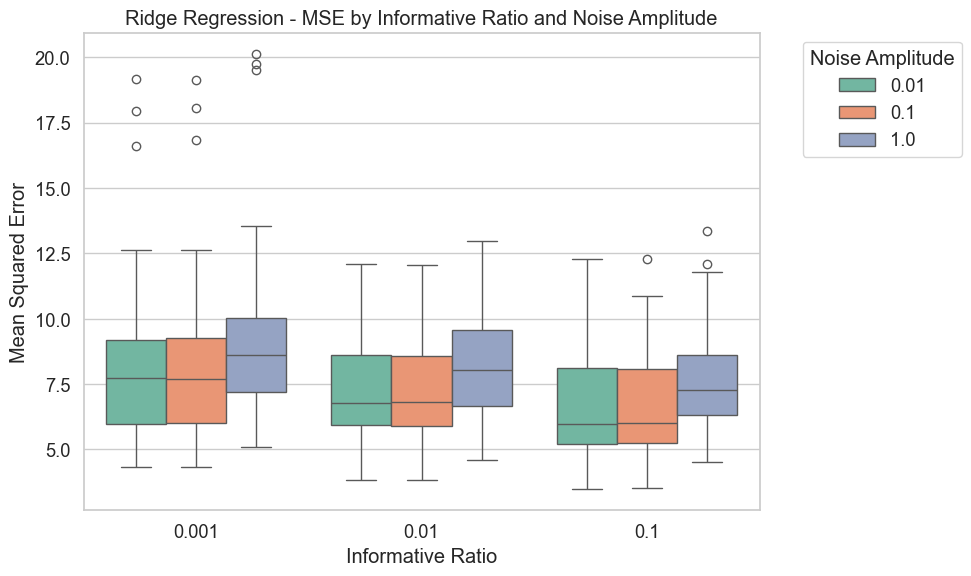

In [6]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot with hue for noise and group by informative ratio
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations_nonlinear,
    x="ir",          # Group by informative ratio on x-axis
    y="mse",         # MSE on y-axis
    hue="noise",     # Different colors for each noise level
    palette="Set2"   # You can change the palette as needed
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Ridge Regression - MSE by Informative Ratio and Noise Amplitude")

# Show legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

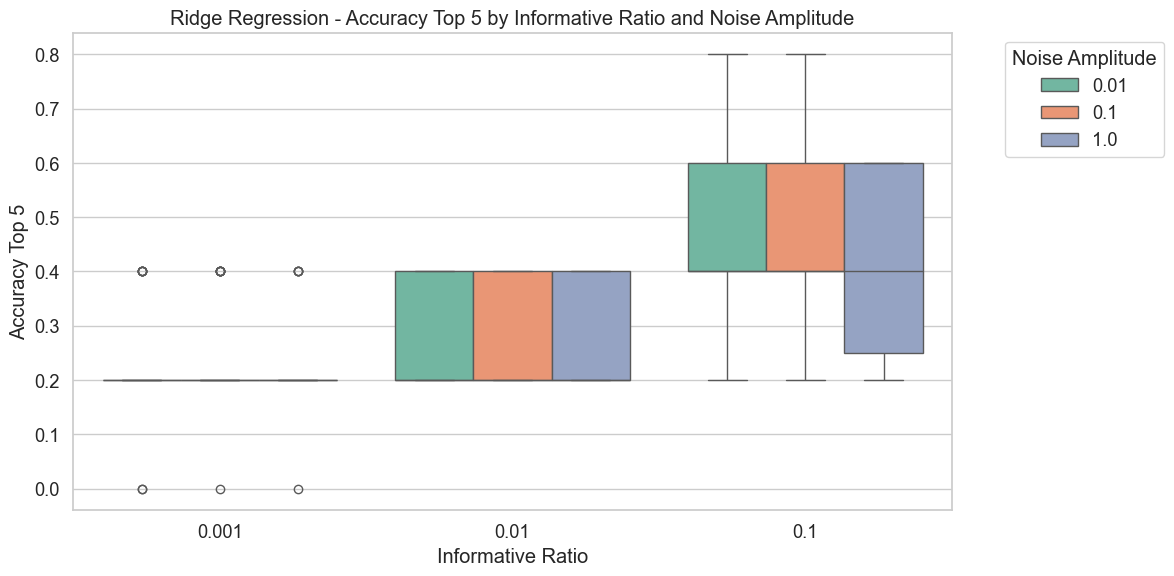

In [7]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations_nonlinear,
    x="ir",          # Informative ratio on x-axis
    y="precision5",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 5")
ax.set_title("Ridge Regression - Accuracy Top 5 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

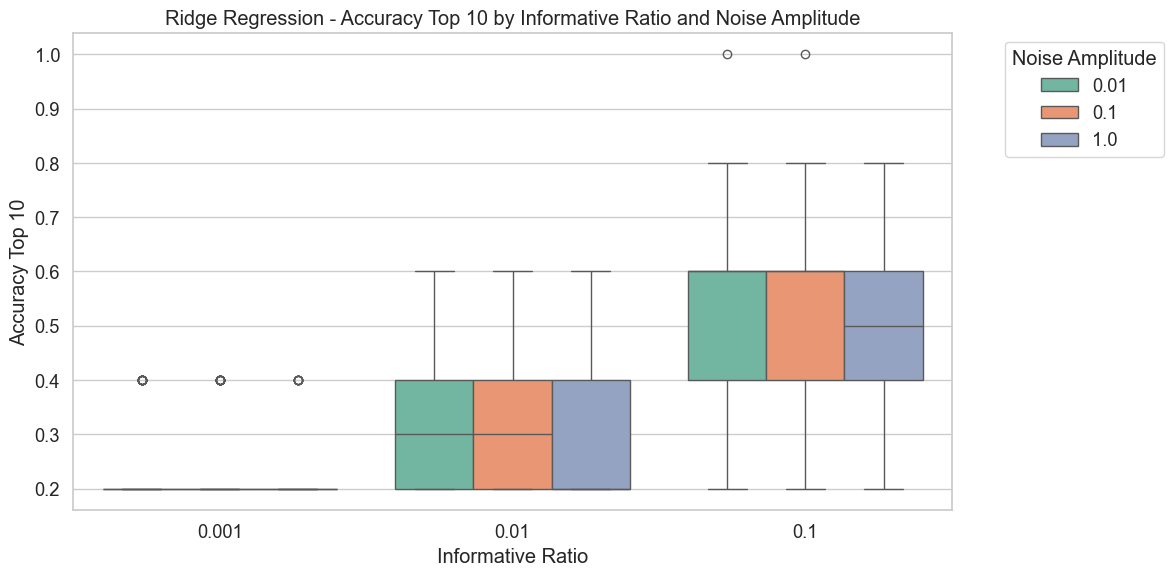

In [8]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Ridge_simulations_nonlinear,
    x="ir",          # Informative ratio on x-axis
    y="precision10",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 10")
ax.set_title("Ridge Regression - Accuracy Top 10 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

## 2.3 Penalized Regression with Lasso (Non-Linear)

In [9]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# alpha_grid = {'lasso__alpha': np.logspace(-4, 4, 30)}
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1, 1]
# n_informative = 5 # Always 5 informative features

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         alpha_list = []
#         selected_features_list = []
#         grid_time_list = []
#         model_coef_list = []
#         correct_selected_features_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = [] 

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_nonlinear_data(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model pipeline with StandardScaler, Lasso and gridSearchCV
#             lasso_pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('lasso', Lasso(max_iter=10000, random_state=42))
#             ])

#             grid_search = GridSearchCV(
#                 lasso_pipeline,
#                 param_grid=alpha_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             coef = best_model.named_steps['lasso'].coef_
#             model_coef_list.append(coef)

#             # Best parameter
#             best_alpha = grid_search.best_params_['lasso__alpha']
#             alpha_list.append(best_alpha)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature selection
#             # Lasso automatically sets coefficients to zero, no need for a threshold
#             n_selected = np.sum(coef != 0)  
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(coef[:n_informative] != 0)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute coefficient magnitude and index
#             coef_magnitudes = np.abs(coef)
#             top_5_indices = np.argsort(coef_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(coef_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of this simulation
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'features_informative': n_informative,
#                 'features_noninformative': n_features - n_informative,
#                 'simulation': sim,
#                 'mse': mse,
#                 'alpha': best_alpha,
#                 'selected_features': n_selected,
#                 'grid time': grid_time,
#                 'model_coef': coef.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })

#         # Save mean results
#         all_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'mean_mse': np.mean(mse_list),
#                 'std_mse': np.std(mse_list),
#                 'modus_alpha': mode(alpha_list, keepdims=True).mode[0],
#                 'mean_selected_total': np.mean(selected_features_list),
#                 'std_selected_total': np.std(selected_features_list),
#                 'mean_correct_selected': np.mean(correct_selected_features_list),
#                 'std_correct_selected': np.std(correct_selected_features_list),
#                 'mean_grid_time': np.mean(grid_time_list),
#                 'std_grid_time': np.std(grid_time_list),
#                 'mean_precision': np.mean(precision_list),
#                 'std_precision': np.std(precision_list),
#                 'mean_recall': np.mean(recall_list),
#                 'std_recall': np.std(recall_list),
#                 'p/n': n_features / n_observations_train,
#                 'mean_precision5': np.mean(precision5_list),
#                 'std_precision5': np.std(precision5_list),
#                 'mean_precision10': np.mean(precision10_list),
#                 'std_precision10': np.std(precision10_list),
#             })
        
# # === Save results to CSV ===
# df_Lasso = pd.DataFrame(all_results)
# df_Lasso.to_csv('df_Lasso_high_dim_nonlinear_all_results.csv', index=False)
# print("DataFrame Lasso has been saved as CSV file.")

# df_Lasso_simulations = pd.DataFrame(all_simulation_results)
# df_Lasso_simulations.to_csv('df_Lasso_high_dim_nonlinear_simulations.csv', index=False)
# print("Saved detailed Lasso simulation results to 'df_Lasso_high_dim_nonlinear_simulations.csv'")


Read dataframe

In [10]:
# Lasso 50 sim
df_lasso_nonlinear = pd.read_csv("df_Lasso_high_dim_nonlinear_all_results.csv")
df_Lasso_simulations_nonlinear = pd.read_csv("df_Lasso_high_dim_nonlinear_simulations.csv")

In [11]:
print(df_lasso_nonlinear.columns)
print(df_Lasso_simulations_nonlinear.columns)

Index(['noise', 'ir', 'features', 'mean_mse', 'std_mse', 'modus_alpha',
       'mean_selected_total', 'std_selected_total', 'mean_correct_selected',
       'std_correct_selected', 'mean_grid_time', 'std_grid_time',
       'mean_precision', 'std_precision', 'mean_recall', 'std_recall', 'p/n',
       'mean_precision5', 'std_precision5', 'mean_precision10',
       'std_precision10'],
      dtype='object')
Index(['noise', 'ir', 'features', 'features_informative',
       'features_noninformative', 'simulation', 'mse', 'alpha',
       'selected_features', 'grid time', 'model_coef',
       'correct_selected_features', 'p/n', 'precision', 'recall', 'precision5',
       'precision10'],
      dtype='object')


### Visulaisations Lasso


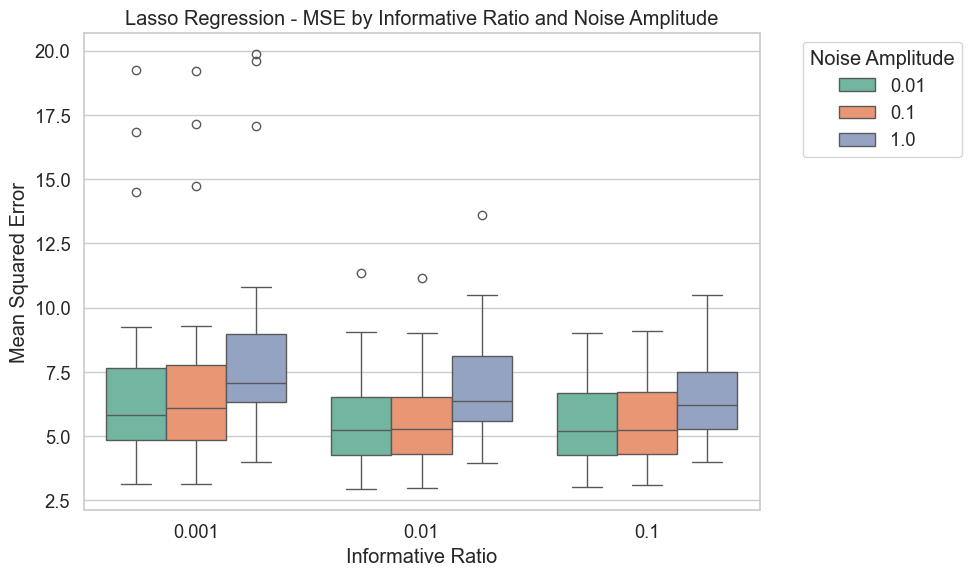

In [12]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot with hue for noise and group by informative ratio
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations_nonlinear,
    x="ir",
    y="mse",
    hue="noise",
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Lasso Regression - MSE by Informative Ratio and Noise Amplitude")

# Show legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


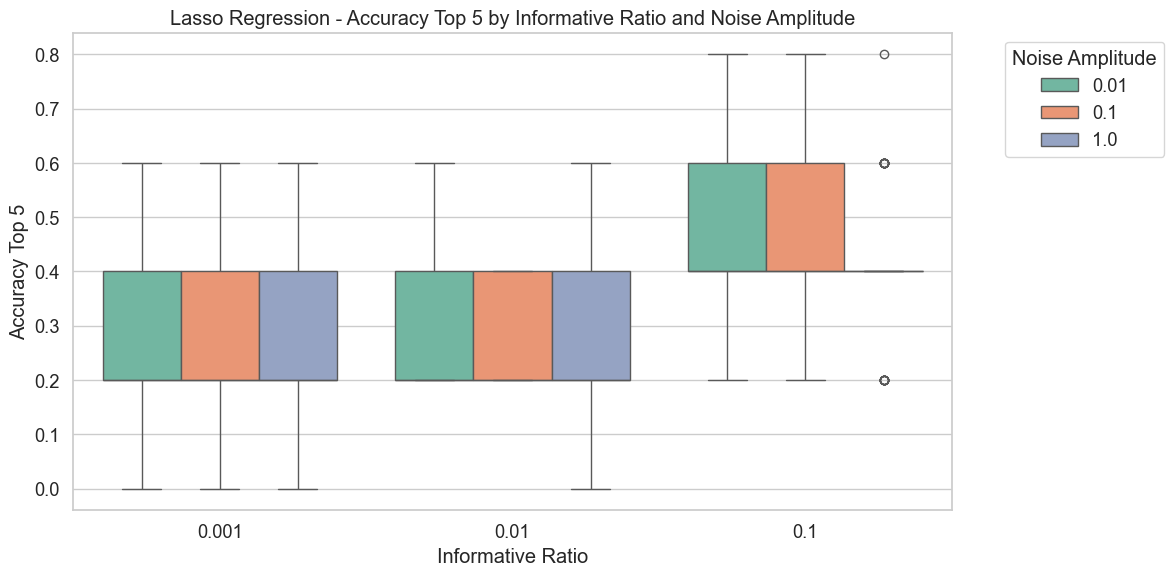

In [13]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations_nonlinear,
    x="ir",          # Informative ratio on x-axis
    y="precision5",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 5")
ax.set_title("Lasso Regression - Accuracy Top 5 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

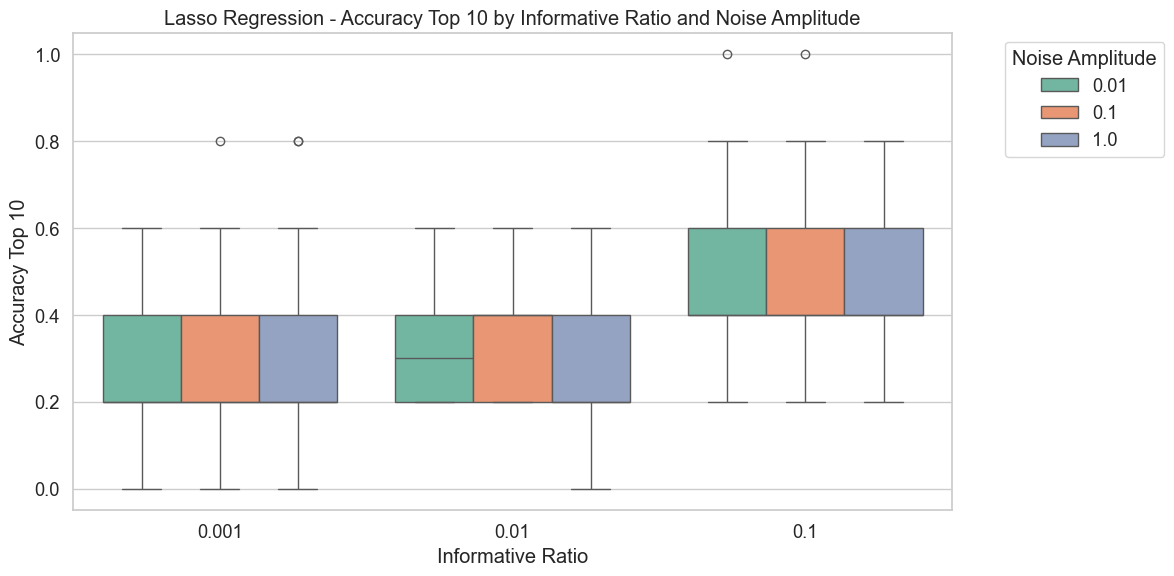

In [14]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_Lasso_simulations_nonlinear,
    x="ir",          # Informative ratio on x-axis
    y="precision10",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 10")
ax.set_title("Lasso Regression - Accuracy Top 10 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

## 2.4 Random Forest (Non-Linear)

In [15]:
# # === Parameters ===
# n_observations_train = 100  # Fixed number of observations for training
# n_observations_test = 100 # Test set of 100 observations
# n_observations = n_observations_test + n_observations_train # Number of total observations to generate
# n_simulations = 50
# n_folds = 5
# informative_ratios = [0.001, 0.01, 0.1]
# noise_amplitudes = [0.01, 0.1, 1]
# n_informative = 5 # Always 5 informative features
# # The parameter grid is dynamic, thus not placed in this parameter list at the top

# # Store results
# all_results = []
# all_simulation_results = []

# # === Loop over noise levels ===
# for noise_amplitude in noise_amplitudes:
#     print(f"\n\n========= Noise Amplitude: {noise_amplitude} =========")

#     for informative_ratio in informative_ratios:
#         print(f"\n\n##### Informative Ratio: {informative_ratio} #####")

#         # Set up lists for storing results
#         mse_list = []
#         selected_features_list = []
#         best_params_list = []
#         grid_time_list = []
#         correct_selected_features_list = []
#         model_importance_list = []
#         precision_list = []
#         recall_list = []
#         precision5_list = []
#         precision10_list = [] 

#         # === Loop over different simulations ===
#         for sim in tqdm(range(n_simulations), desc=f"Sim {informative_ratio} features"):
#             seed = 42 + sim

#             # Generate data with fixed observations and varying features
#             X, y, n_features = generate_nonlinear_data(n_observations, n_informative, informative_ratio, noise_amplitude, seed)

#             # Split explicitly into 100 train and 100 test
#             X_train, y_train = X[:n_observations_train], y[:n_observations_train]
#             X_test, y_test = X[n_observations_train:], y[n_observations_train:]

#             # Set up model Random Forest and GridSearchCV
#             # No scaling needed for Random Forest
#             rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#             rf_param_grid = {
#                 'n_estimators': [100, 200, 300, 400, 500],  # Fixed number of estimators
#                 'max_depth': [None, 10, 20],
#                 'min_samples_split': [2, 5],
#                 'min_samples_leaf': [1, 2, 4],
#                 'max_features': ['sqrt','log2', 1, max(1, n_features // 3)] # p/3 added
#             }
            
#             grid_search = GridSearchCV(
#                 rf,
#                 param_grid=rf_param_grid,
#                 cv=n_folds,
#                 scoring='neg_mean_squared_error',
#                 n_jobs=-1
#             )

#             # GridSearchCV
#             start_grid = time.time()
#             grid_search.fit(X_train, y_train)
#             grid_time = time.time() - start_grid
#             grid_time_list.append(grid_time)

#             # Best model
#             best_model = grid_search.best_estimator_
#             model_importance_list.append(best_model.feature_importances_)

#             # Best parameter
#             best_params = grid_search.best_params_
#             best_params_list.append(best_params)

#             # Prediction and MSE
#             y_pred = best_model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#             # Feature Selection
#             importance_threshold = 1e-3
#             model_importance = best_model.feature_importances_
#             n_selected = np.sum(model_importance > importance_threshold)
#             selected_features_list.append(n_selected)

#             # Number of correctly selected features
#             correct_selected_features = np.sum(np.abs(best_model.feature_importances_[:n_informative]) > importance_threshold)
#             correct_selected_features_list.append(correct_selected_features)

#             # Precision and Recall
#             precision = 0 if n_selected == 0 else correct_selected_features / n_selected
#             recall = correct_selected_features / n_informative
#             precision_list.append(precision)
#             recall_list.append(recall)

#             # Top-k features correct based on absolute importance magnitude and index
#             importance_magnitudes = np.abs(model_importance)
#             top_5_indices = np.argsort(importance_magnitudes)[-5:][::-1]  
#             top_10_indices = np.argsort(importance_magnitudes)[-10:][::-1]  
#             correct_top_5 = np.sum(top_5_indices < n_informative)
#             correct_top_10 = np.sum(top_10_indices < n_informative)

#             # New metrics precision5 and precision10
#             precision5 = correct_top_5 / 5
#             precision10 = correct_top_10 / 5
#             precision5_list.append(precision5)
#             precision10_list.append(precision10)

#             # Save all results of the simulations
#             all_simulation_results.append({
#                 'noise': noise_amplitude,
#                 'ir': informative_ratio,
#                 'features': n_features,
#                 'simulation': sim,
#                 'mse': mse,
#                 'selected_features': n_selected,
#                 'n_estimators': best_params['n_estimators'],
#                 'max_depth': best_params['max_depth'],
#                 'min_samples_split': best_params['min_samples_split'],
#                 'min_samples_leaf': best_params['min_samples_leaf'],
#                 'max_features': best_params['max_features'],
#                 'grid_time' : grid_time,
#                 'model_importance' : model_importance.tolist(),
#                 'correct_selected_features': correct_selected_features,
#                 'p/n': n_features / n_observations_train,
#                 'precision': precision,
#                 'recall': recall,
#                 'precision5': precision5,
#                 'precision10': precision10,
#             })   

#         # get mode per parameter
#         def get_mode(lst):
#             return Counter(lst).most_common(1)[0][0]

#         # Extract each parameter list
#         n_estimators_modes = get_mode([p['n_estimators'] for p in best_params_list])
#         max_depth_modes = get_mode([p['max_depth'] for p in best_params_list])
#         min_samples_split_modes = get_mode([p['min_samples_split'] for p in best_params_list])
#         min_samples_leaf_modes = get_mode([p['min_samples_leaf'] for p in best_params_list])
#         max_features_modes = get_mode([p['max_features'] for p in best_params_list])

#         # Save the mean results      
#         all_results.append({
#             'noise': noise_amplitude,
#             'ir': informative_ratio,
#             'features': n_features,
#             'mean_mse': np.mean(mse_list),
#             'std_mse': np.std(mse_list),
#             'mean_selected': np.mean(selected_features_list),
#             'std_selected': np.std(selected_features_list),
#             'mode_n_estimators': n_estimators_modes,
#             'mode_max_depth': max_depth_modes,
#             'mode_min_samples_split': min_samples_split_modes,
#             'mode_min_samples_leaf': min_samples_leaf_modes,
#             'mode_max_features': max_features_modes,
#             'mean_grid_time' : np.mean(grid_time_list),
#             'std_grid_time' : np.std(grid_time_list),
#             'mean_correct_selected': np.mean(correct_selected_features_list),
#             'std_correct_selected': np.std(correct_selected_features_list),
#             'mean_precision': np.mean(precision_list),
#             'std_precision': np.std(precision_list),
#             'mean_recall': np.mean(recall_list),
#             'std_recall': np.std(recall_list),
#             'p/n': n_features / n_observations_train,
#             'mean_precision5': np.mean(precision5_list),
#             'std_precision5': np.std(precision5_list),
#             'mean_precision10': np.mean(precision10_list),
#             'std_precision10': np.std(precision10_list),
#         })
        
# # === Save results to CSV ===
# df_RF = pd.DataFrame(all_results)
# df_RF.to_csv('df_RF_high_dim_nonlinear_all_results.csv', index=False)
# print("DataFrame RF has been saved as CSV file.")

# df_RF_simulations = pd.DataFrame(all_simulation_results)
# df_RF_simulations.to_csv('df_RF_high_dim_nonlinear_simulations.csv', index=False)
# print("Saved detailed RF simulation results to 'df_RF_high_dim_nonlinear_simulations.csv'")

Read dataframe

In [16]:
# RF 50 sim
df_RF_nonlinear = pd.read_csv("df_RF_high_dim_nonlinear_all_results.csv")
df_RF_simulations_nonlinear = pd.read_csv("df_RF_high_dim_nonlinear_simulations.csv")

In [17]:
print(df_RF_nonlinear.columns)
print(df_RF_simulations_nonlinear.columns)

Index(['noise', 'ir', 'features', 'mean_mse', 'std_mse', 'mean_selected',
       'std_selected', 'mode_n_estimators', 'mode_max_depth',
       'mode_min_samples_split', 'mode_min_samples_leaf', 'mode_max_features',
       'mean_grid_time', 'std_grid_time', 'mean_correct_selected',
       'std_correct_selected', 'mean_precision', 'std_precision',
       'mean_recall', 'std_recall', 'p/n', 'mean_precision5', 'std_precision5',
       'mean_precision10', 'std_precision10'],
      dtype='object')
Index(['noise', 'ir', 'features', 'simulation', 'mse', 'selected_features',
       'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
       'max_features', 'grid_time', 'model_importance',
       'correct_selected_features', 'p/n', 'precision', 'recall', 'precision5',
       'precision10'],
      dtype='object')


### Visualisations Random Forests

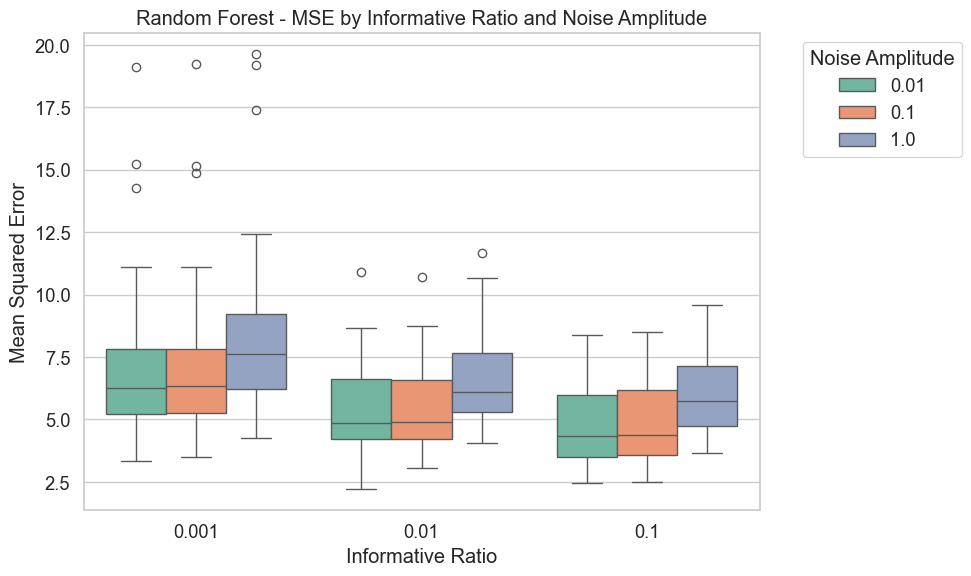

In [18]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_RF_simulations_nonlinear,
    x="ir",
    y="mse",
    hue="noise",
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Random Forest - MSE by Informative Ratio and Noise Amplitude")

plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


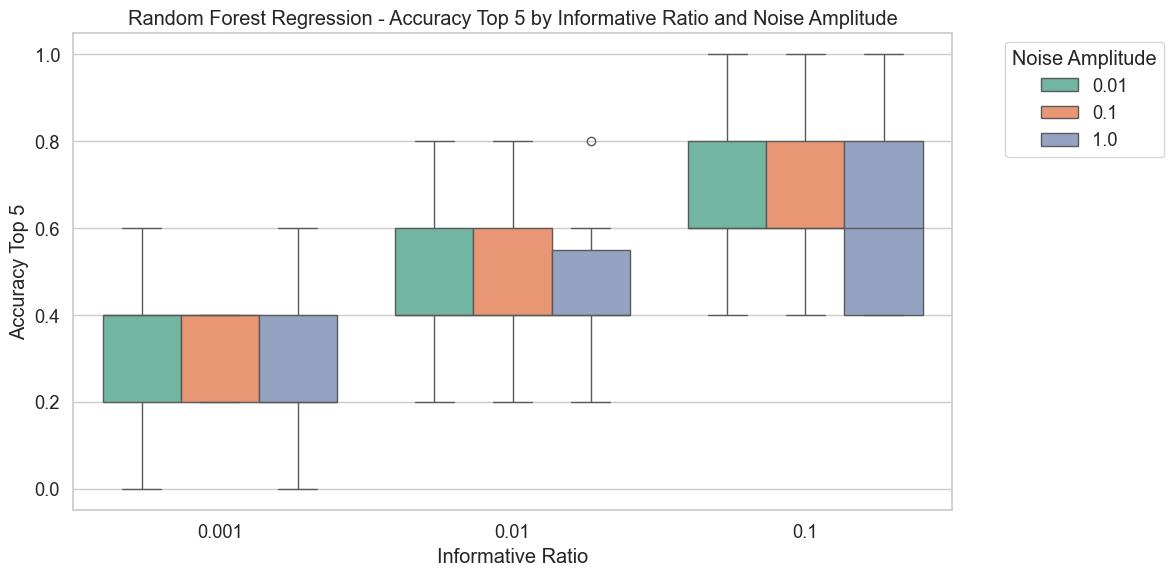

In [19]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_RF_simulations_nonlinear,
    x="ir",          # Informative ratio on x-axis
    y="precision5",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 5")
ax.set_title("Random Forest Regression - Accuracy Top 5 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

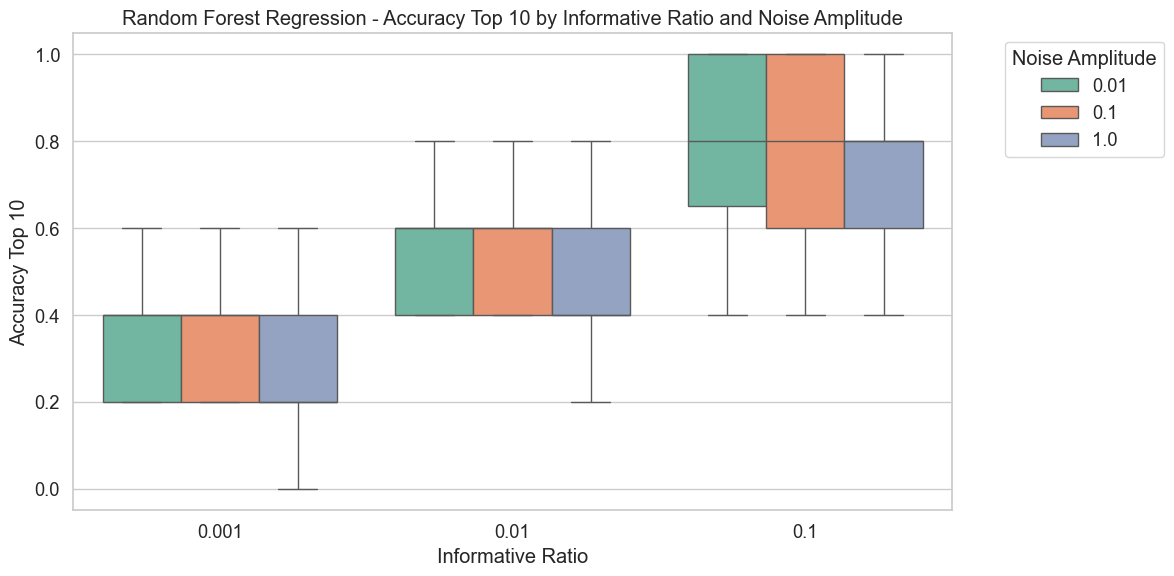

In [20]:
# Set up plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create the boxplot for all informative ratios
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_RF_simulations_nonlinear,
    x="ir",          # Informative ratio on x-axis
    y="precision10",         
    hue="noise",     # Different colors for each noise level
    palette="Set2"
)

# Set axis labels and title
ax.set_xlabel("Informative Ratio")
ax.set_ylabel("Accuracy Top 10")
ax.set_title("Random Forest Regression - Accuracy Top 10 by Informative Ratio and Noise Amplitude")

# Apply log scale to the y-axis
#ax.set_yscale("log")

# Adjust legend
plt.legend(title="Noise Amplitude", bbox_to_anchor=(1.05, 1), loc="upper left")

# Tight layout and show plot
plt.tight_layout()
plt.show()

## 2.5 Results Non-Linear Data

In [21]:
# Add a 'model' label
df_Ridge_simulations_nonlinear['model'] = 'Ridge'
df_Lasso_simulations_nonlinear['model'] = 'Lasso'
df_RF_simulations_nonlinear['model'] = 'Random Forest'

# Combine them
df_all_nonlinear = pd.concat([df_Ridge_simulations_nonlinear, df_Lasso_simulations_nonlinear, df_RF_simulations_nonlinear], ignore_index=True)


Visualise Results MSE

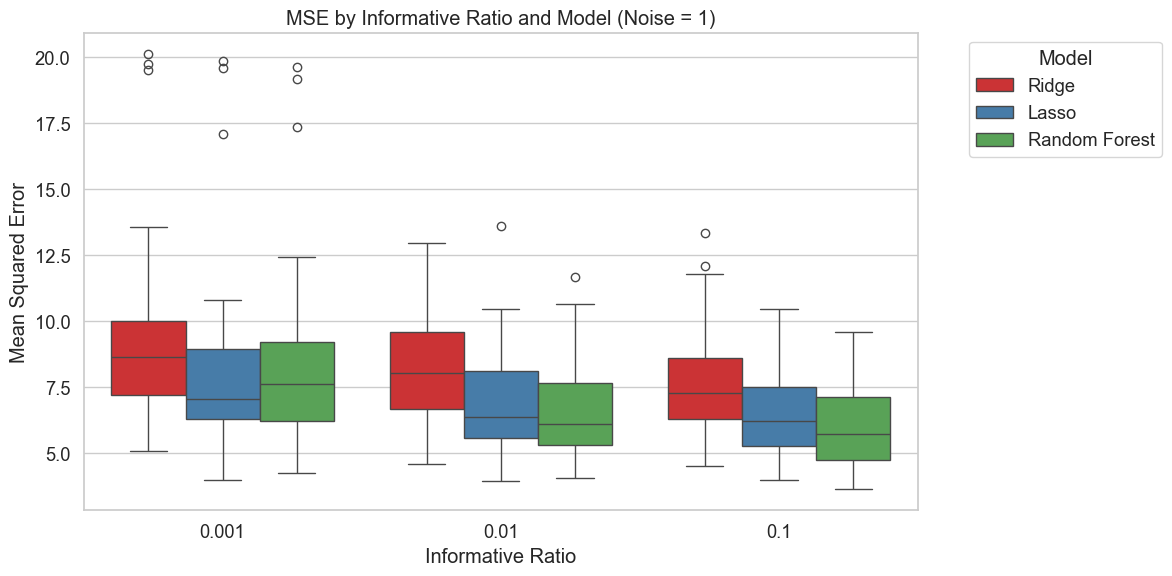

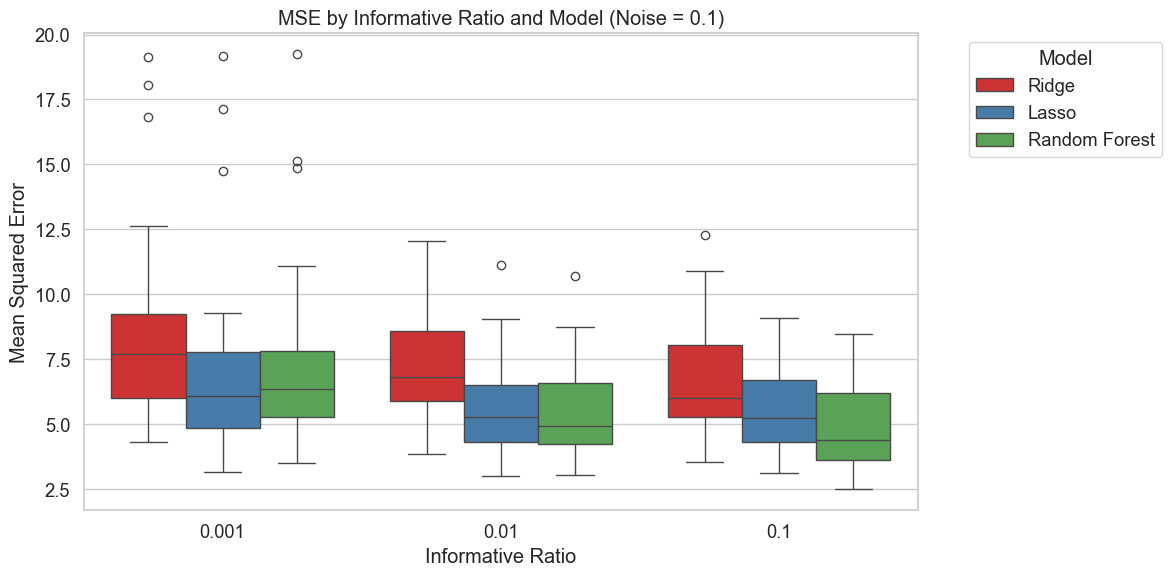

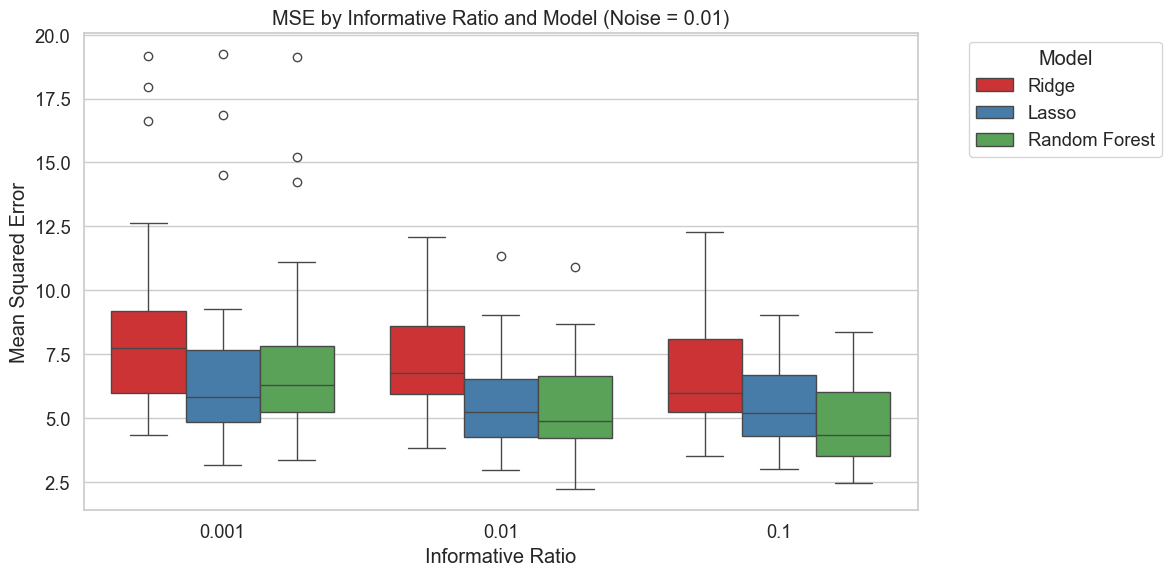

In [22]:
def plot_by_noise(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='mse',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'MSE by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Mean Squared Error')
    # Optional: uncomment next line for log scale
    # ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise =.1
plot_by_noise(df_all_nonlinear, 1)

# Plot for noise = 0.1
plot_by_noise(df_all_nonlinear, 0.1)

# Plot for noise = 0.01
plot_by_noise(df_all_nonlinear, 0.01)

Precision

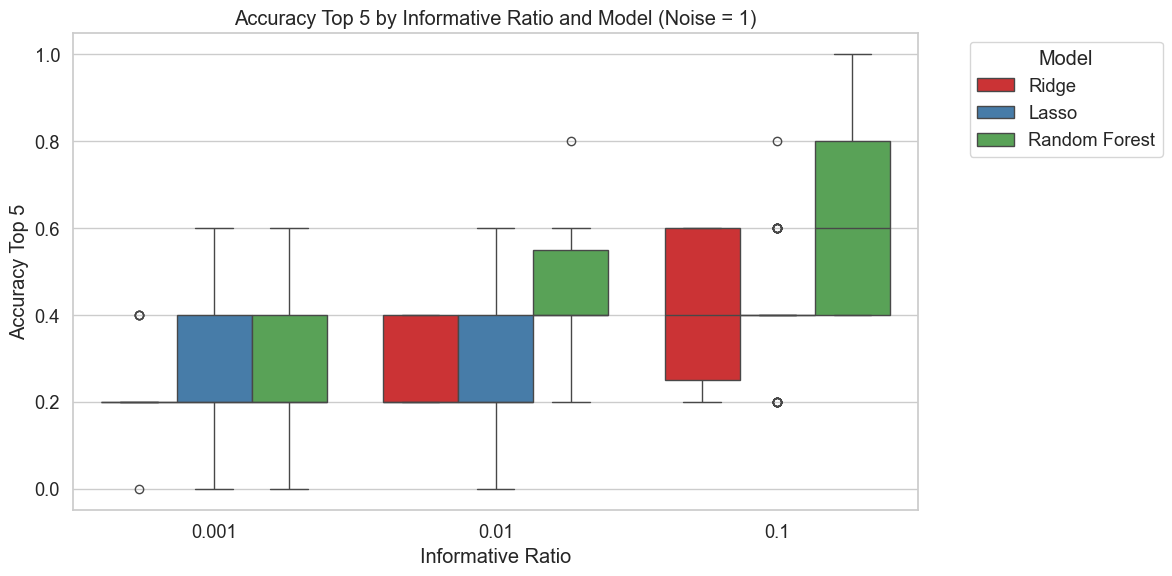

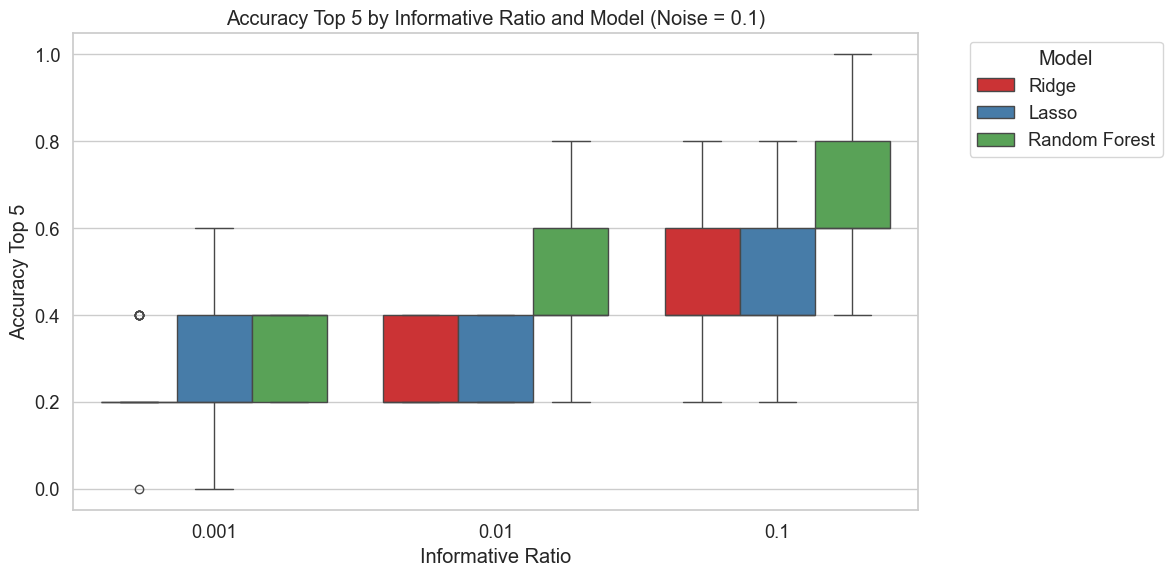

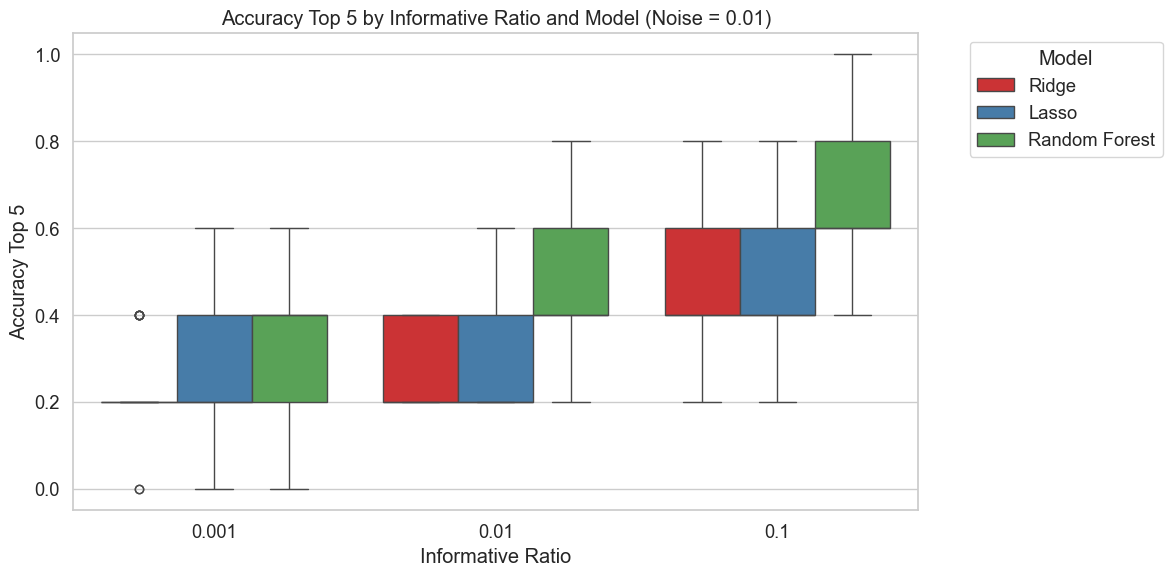

In [23]:
def plot_by_noise_precision(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='precision5',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'Accuracy Top 5 by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Accuracy Top 5')
    # Optional: uncomment next line for log scale
    # ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise = 1
plot_by_noise_precision(df_all_nonlinear, 1)

# Plot for noise = 0.1
plot_by_noise_precision(df_all_nonlinear, 0.1)

# Plot for noise = 0.01
plot_by_noise_precision(df_all_nonlinear, 0.01)

Recall

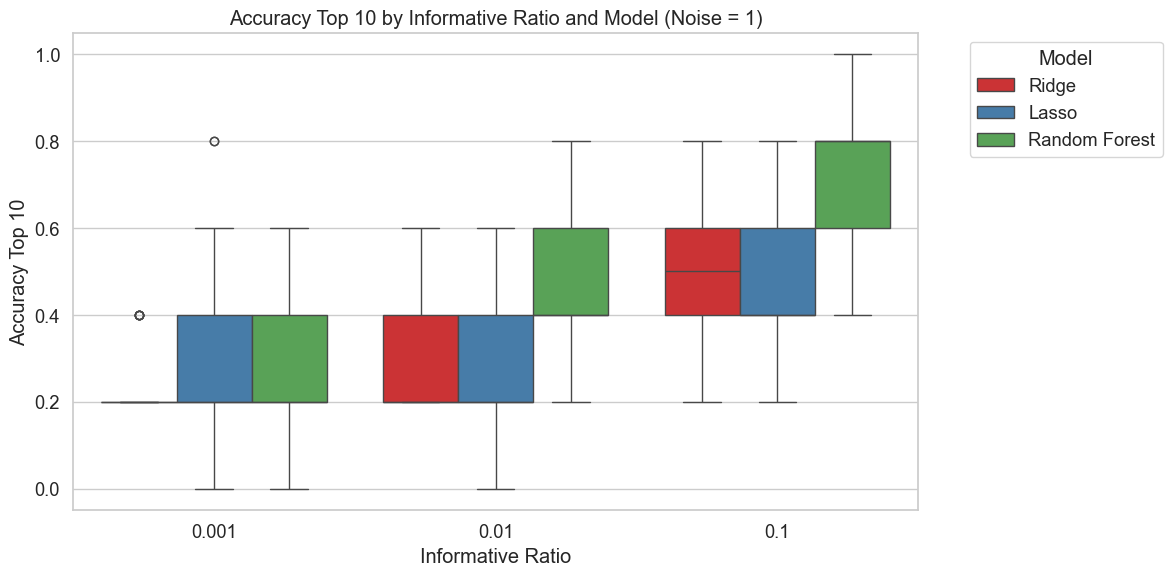

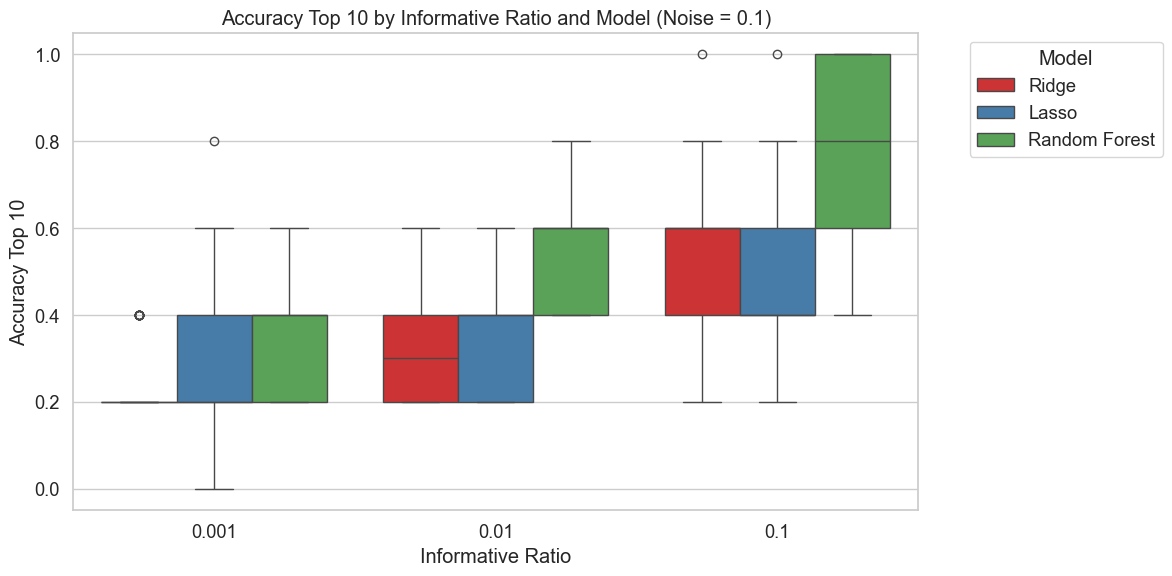

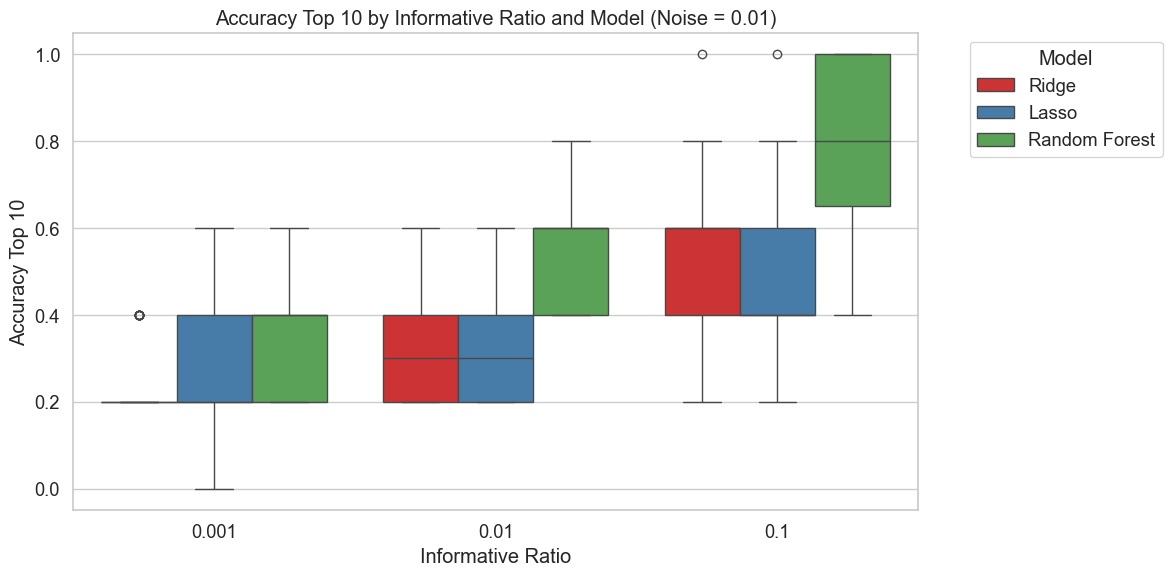

In [24]:
def plot_by_noise_precision(df, noise_level):
    # Filter by noise level
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',             # informative ratio on x-axis
        y='precision10',
        hue='model',        # different colors per model
        palette='Set1',
        dodge=True           # separate boxplots side-by-side per x category
    )

    ax.set_title(f'Accuracy Top 10 by Informative Ratio and Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Accuracy Top 10')
    # Optional: uncomment next line for log scale
    # ax.set_yscale('log')

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot for noise =1
plot_by_noise_precision(df_all_nonlinear,1)

# Plot for noise = 0.1
plot_by_noise_precision(df_all_nonlinear, 0.1)

# Plot for noise = 0.01
plot_by_noise_precision(df_all_nonlinear, 0.01)

### Time

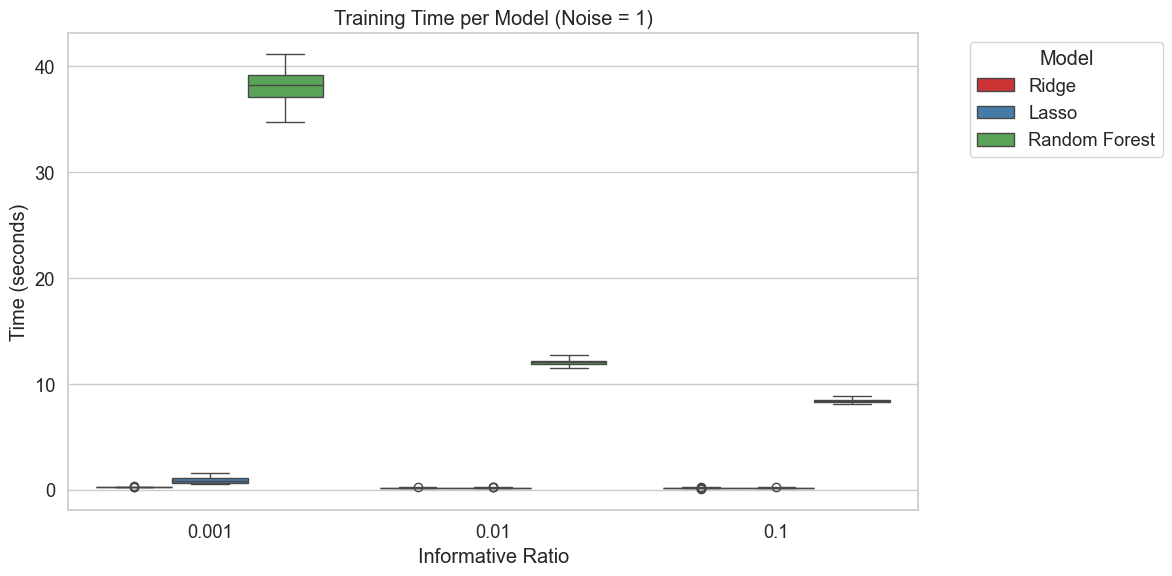

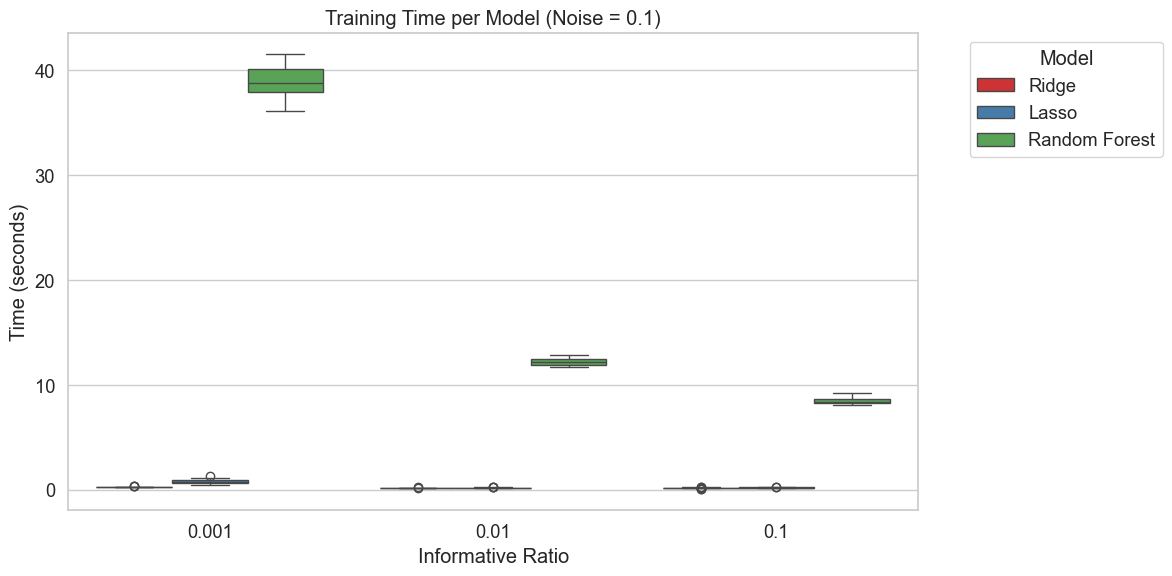

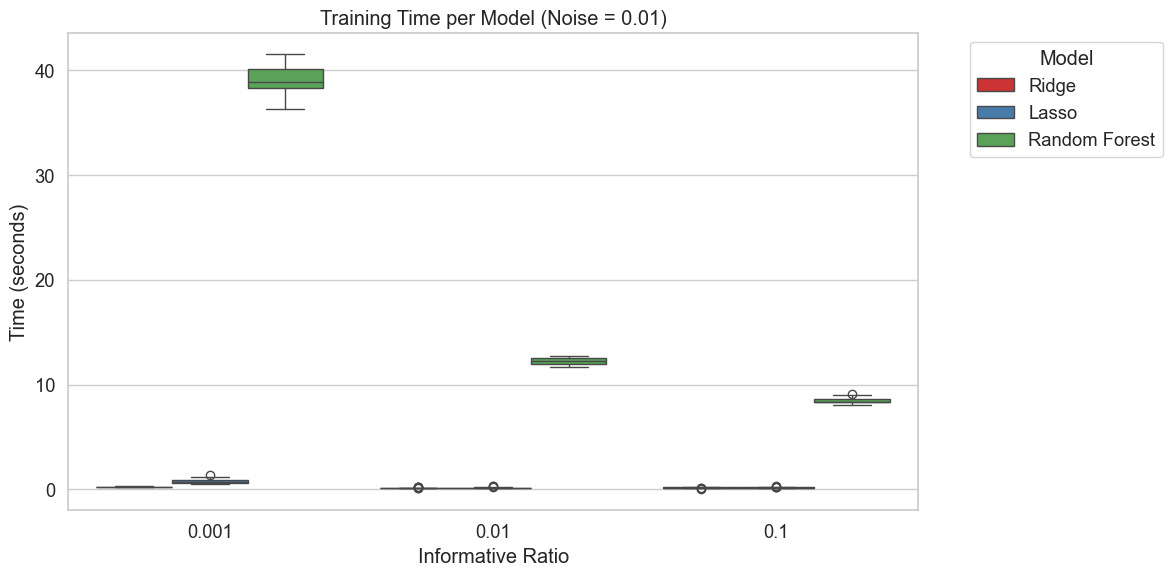

In [25]:
# Random Forest (RF)
df_RF_simulations_nonlinear['grid time'] = df_RF_simulations_nonlinear['grid_time'] 

df_Ridge_simulations_nonlinear['model'] = 'Ridge'
df_Lasso_simulations_nonlinear['model'] = 'Lasso'
df_RF_simulations_nonlinear['model'] = 'Random Forest'

df_combined_nonlinear = pd.concat([
    df_Ridge_simulations_nonlinear[['noise', 'ir', 'model', 'grid time']],
    df_Lasso_simulations_nonlinear[['noise', 'ir', 'model', 'grid time']],
    df_RF_simulations_nonlinear[['noise', 'ir', 'model', 'grid time']]
])

def plot_fair_fit_time_nonlinear(df, noise_level):
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',
        y='grid time',
        hue='model',
        palette='Set1',
        dodge=True
    )

    ax.set_title(f'Training Time per Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Time (seconds)')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_fair_fit_time_nonlinear(df_combined_nonlinear, 1)
plot_fair_fit_time_nonlinear(df_combined_nonlinear, 0.1)
plot_fair_fit_time_nonlinear(df_combined_nonlinear, 0.01)


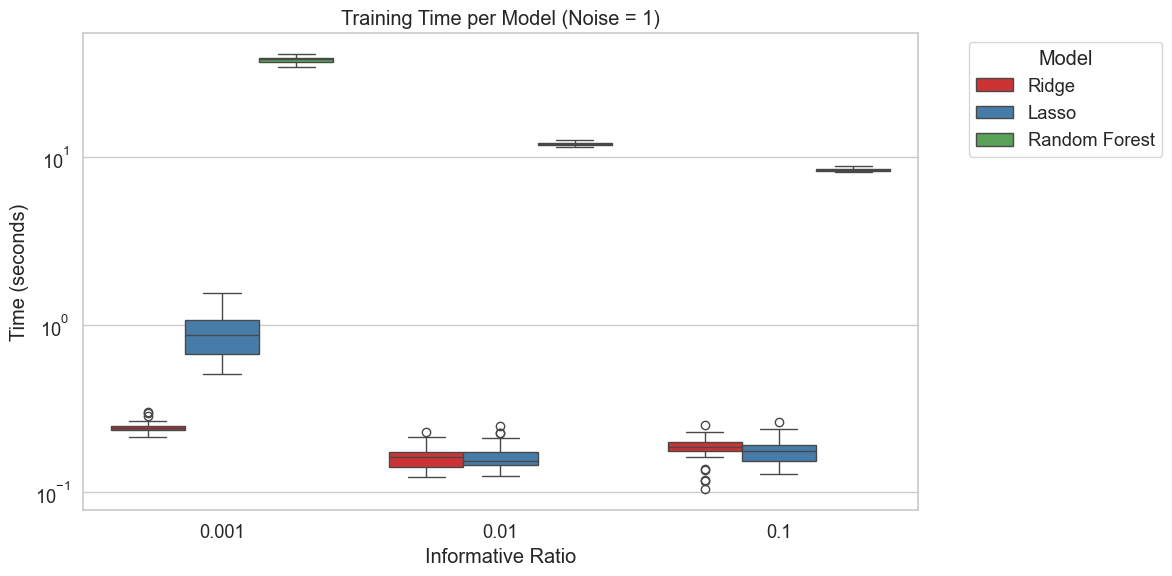

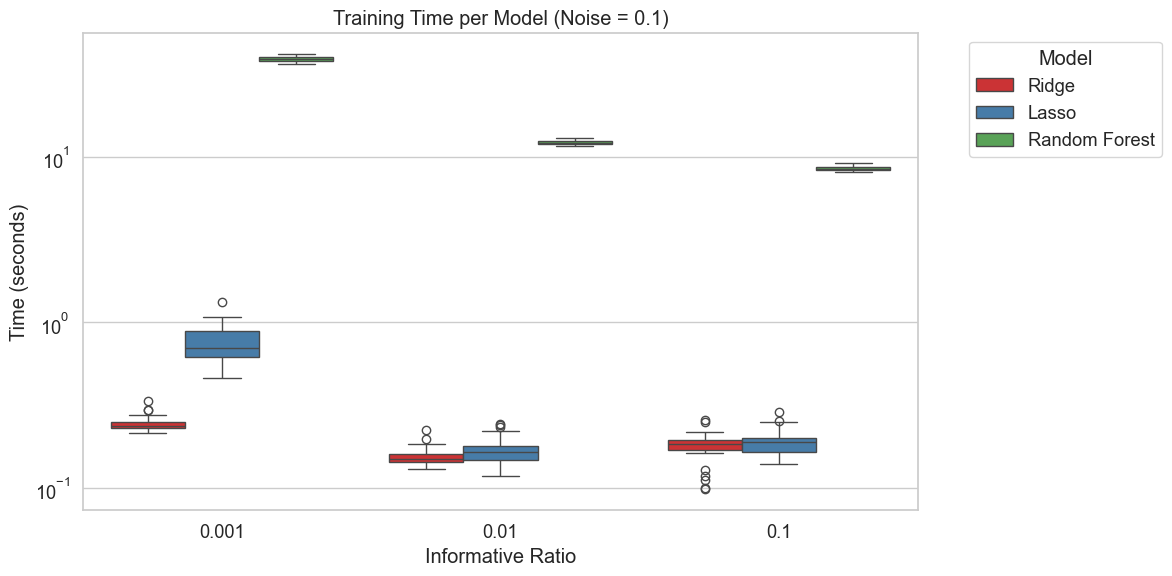

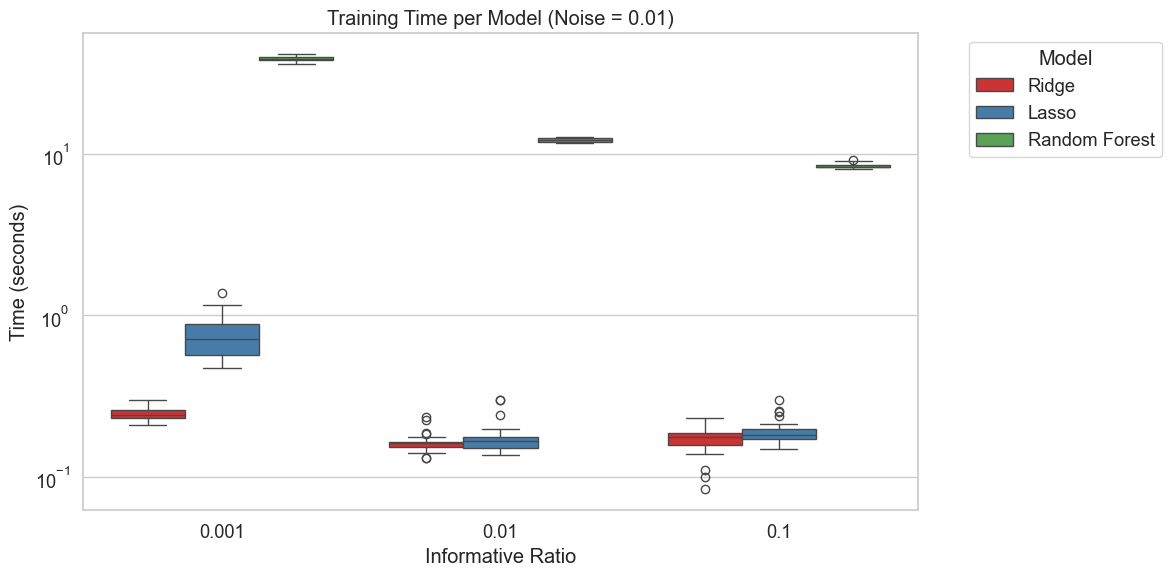

In [26]:
def plot_fair_fit_time_nonlinear(df, noise_level):
    df_noise = df[df['noise'] == noise_level]

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        data=df_noise,
        x='ir',
        y='grid time',
        hue='model',
        palette='Set1',
        dodge=True
    )

    ax.set_title(f'Training Time per Model (Noise = {noise_level})')
    ax.set_xlabel('Informative Ratio')
    ax.set_ylabel('Time (seconds)')
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

plot_fair_fit_time_nonlinear(df_combined_nonlinear, 1)
plot_fair_fit_time_nonlinear(df_combined_nonlinear, 0.1)
plot_fair_fit_time_nonlinear(df_combined_nonlinear, 0.01)